In [17]:
import os 
from IPython.display import clear_output

import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

import seaborn as sns
import plotly.graph_objects as go
from plotly.offline import iplot
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams.update({'font.size': 11})

import warnings 
warnings.simplefilter('ignore')
import pickle

from itertools import product
from tqdm import tqdm

from functions.train_test_wells import train_test_wells

with open('../name_wells_pickle/dict_name_well.pickle', 'rb') as f:
    dict_name_well = pickle.load(f)

%config InlineBackend.figure_formats = 'svg'

In [20]:
df = pd.read_csv('../../data/data_for_model/linear_regression/1.1_5_days_ago_not_stationary.csv')
df.set_index('MEASURED_IN_DATE', inplace=True)
well = 1
data = df[df['WELL_NAME'] == well]

y = data['TARGET_OIL_RATE']
X = data.drop(columns=['TARGET_OIL_RATE'])

<Axes: >

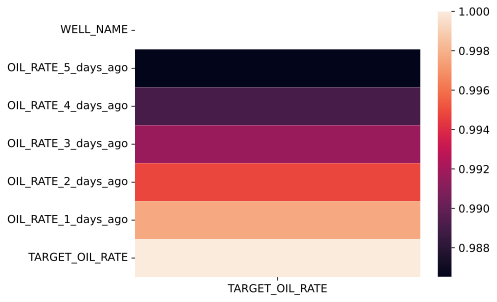

In [21]:
corr_target = pd.DataFrame(df[df['WELL_NAME'] == 1].corr()['TARGET_OIL_RATE'])
sns.heatmap(corr_target)

In [3]:
test_size = 30
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=7, shuffle=False)

In [201]:
poly_features = PolynomialFeatures(degree=2, include_bias=False)
columns_for_poly = ['OIL_RATE_1_days_ago']
other_columns = [column for column in X_train.columns if column not in columns_for_poly]
column_transform = ColumnTransformer(transformers=[
    ('poly', poly_features, columns_for_poly),
    ('other', 'passthrough', other_columns)
])


model = make_pipeline(column_transform, 
                      StandardScaler(with_mean=True), 
                      LinearRegression(n_jobs=-1))

In [195]:
model.fit(X_train, y_train)
weights = model.named_steps.linearregression.coef_
weights

array([ 1.63597314e+01,  1.39892972e-01,  4.21884749e-15,  9.72373472e-02,
        8.61415946e-01, -1.69134759e+00, -4.93394846e-01])

In [196]:
poly_features = model.named_steps.columntransformer
standard_scaler = model.named_steps.standardscaler
linear_reg = model.named_steps.linearregression

data = X_test.iloc[[0]]

total_points = X_test.shape[0]
count_feature = 5  #data.shape[0]

answer = []

for point in range(total_points):
    data_next_point = standard_scaler.transform(column_transform.transform(data))
    value_point = linear_reg.predict(data_next_point) 

    answer.append(value_point)
    
    if len(answer) == total_points:
        break
        
    data.index = [X_test.index[point + 1]]
    data.iloc[:, : - count_feature] = [X_test.iloc[point + 1, : - count_feature]]
    
    data.iloc[:, - count_feature : -1] = data.iloc[:, - count_feature + 1 :];
    data.iloc[:, - 1] = value_point
    
answer = pd.Series(answer, index=y_test.index).astype('float')

In [197]:
MSE = mean_squared_error(y_test, answer) 
MAE = mean_absolute_error(y_test, answer)

In [198]:
from functions.graph_with_prediction import graph_with_prediction
graph_with_prediction(y_train=y_train, y_test=y_test, answer_model=answer, model_name='Линейная регрессия')

In [326]:
data_name = '1.3_50_days_ago_not_stationary'
path_to_data = f'../../data/data_for_model/linear_regression/{data_name}'
df = pd.read_csv(path_to_data)
df['MEASURED_IN_DATE'] = pd.to_datetime(df['MEASURED_IN_DATE'])
df.set_index('MEASURED_IN_DATE', inplace=True)

[1,
 4,
 15,
 21,
 27,
 28,
 29,
 30,
 32,
 34,
 36,
 37,
 38,
 39,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 53,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 67,
 68,
 69,
 70,
 71,
 73,
 74,
 75,
 76,
 77,
 78,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 93,
 94,
 95,
 97,
 100,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 114,
 115,
 116,
 117,
 118,
 120,
 122,
 126,
 130,
 131,
 133,
 136,
 148,
 150,
 151,
 156,
 157,
 158,
 159,
 160,
 167,
 168,
 170,
 173,
 178,
 180,
 181,
 182,
 185,
 186,
 187,
 189,
 191,
 192,
 193,
 194,
 195,
 196,
 198,
 199,
 202,
 205,
 210,
 218,
 225,
 226,
 227,
 229,
 230,
 231,
 233,
 234,
 235,
 236,
 237,
 239,
 241,
 242,
 244,
 245,
 246,
 247,
 249,
 250,
 251,
 252,
 254,
 257,
 258]

In [310]:
test_sizes = [30, 45, 60, 120]
poly_degrees = [2, 3, 4, 5, 6, 7]
count_features = [5, 20, 50]
wells = list(df['WELL_NAME'].unique())
feature_degrees = [['OIL_RATE_1_days_ago'], ['P_ZAB'], ['OIL_RATE_1_days_ago', 'P_ZAB']]
parameters = product(test_sizes, poly_degrees, count_features, wells, feature_degrees)
parameters_list = list(parameters)


for param in tqdm(parameters_list, colour='green'):
    
    test_size = param[0]
    poly_degree = param[1]
    count_feature = param[2]
    well = param[3]
    feature_degree = param[4]
    
    data = df[df['WELL_NAME'] == well]

    y = data['TARGET_OIL_RATE']
    X = data.drop(columns=['TARGET_OIL_RATE'])
    
    try:
    ####
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=7, shuffle=False)

    ####
    
        poly_features = PolynomialFeatures(degree=poly_degree, include_bias=False)
        columns_for_poly = feature_degree
        other_columns = [column for column in X_train.columns if column not in columns_for_poly]
        column_transform = ColumnTransformer(transformers=[
            ('poly', poly_features, columns_for_poly),
            ('other', 'passthrough', other_columns)
        ])


        model = make_pipeline(column_transform, 
                              StandardScaler(with_mean=True), 
                              LinearRegression(n_jobs=-1))

        ####
        model.fit(X_train, y_train)
        weights = model.named_steps.linearregression.coef_
        ####

        poly_features = model.named_steps.columntransformer
        standard_scaler = model.named_steps.standardscaler
        linear_reg = model.named_steps.linearregression

        data = X_test.iloc[[0]]

        total_points = X_test.shape[0]


        answer = []

        for point in range(total_points):
            data_next_point = standard_scaler.transform(column_transform.transform(data))
            value_point = linear_reg.predict(data_next_point) 

            answer.append(value_point)

            if len(answer) == total_points:
                break

            data.index = [X_test.index[point + 1]]
            data.iloc[:, : - count_feature] = [X_test.iloc[point + 1, : - count_feature]]

            data.iloc[:, - count_feature : -1] = data.iloc[:, - count_feature + 1 :];
            data.iloc[:, - 1] = value_point

        answer = pd.Series(answer, index=y_test.index).astype('float')

        ####

        MSE = mean_squared_error(y_test, answer) 
        MAE = mean_absolute_error(y_test, answer)


        ####

        uppend_feature_degree = ' '.join(feature_degree)
        result.loc[result.shape[0]] = [data_name, well, 
                                       poly_degree, 
                                       count_feature, 
                                       test_size, 
                                       uppend_feature_degree, 
                                       MSE, 
                                       MAE]
        
        result.drop_duplicates(inplace=True)
        
    except ValueError:
        uppend_feature_degree = ' '.join(feature_degree)
        result.loc[result.shape[0]] = [data_name, 
                                       well, poly_degree, 
                                       count_feature, 
                                       test_size, 
                                       uppend_feature_degree, 
                                       np.nan, 
                                       np.nan]
        result.drop_duplicates(inplace=True)
        continue
result

100%|██████████████████████████████████████████████████████████████████████████| 30672/30672 [1:25:52<00:00,  5.95it/s]


,DATAFRAME_NAME,WELL_NAME,POLY_DEGREE,DAY_AGO,PREDICT_DAYS,FEATURE_DEGREE,MSE,MAE
0,1.1_5_days_ago_not_stationary,1,2,5,30,OIL_RATE_1_days_ago,4.665383,1.674921
1,1.1_5_days_ago_not_stationary,1,2,5,30,P_ZAB,NaN,NaN
2,1.1_5_days_ago_not_stationary,1,2,5,30,OIL_RATE_1_days_ago P_ZAB,NaN,NaN
3,1.1_5_days_ago_not_stationary,4,2,5,30,OIL_RATE_1_days_ago,109.348036,8.776655
4,1.1_5_days_ago_not_stationary,4,2,5,30,P_ZAB,NaN,NaN
...,...,...,...,...,...,...,...,...
92011,1.3_50_days_ago_not_stationary,257,7,50,120,P_ZAB,NaN,NaN
92012,1.3_50_days_ago_not_stationary,257,7,50,120,OIL_RATE_1_days_ago P_ZAB,NaN,NaN
92013,1.3_50_days_ago_not_stationary,258,7,50,120,OIL_RATE_1_days_ago,NaN,NaN
92014,1.3_50_days_ago_not_stationary,258,7,50,120,P_ZAB,NaN,NaN


result = pd.DataFrame(columns=['DATAFRAME_NAME', 'WELL_NAME', 'POLY_DEGREE', 'DAY_AGO', 'PREDICT_DAYS', 'FEATURE_DEGREE', 'MSE', 'MAE'], )

result

In [3]:
result.to_csv('../../data/data_for_model/linear_regression/result')

NameError: name 'result' is not defined

In [315]:
result[~result['WELL_NAME'].isin([29, 160, 7])].sort_values(['MSE', 'MAE']).head(10)

,DATAFRAME_NAME,WELL_NAME,POLY_DEGREE,DAY_AGO,PREDICT_DAYS,FEATURE_DEGREE,MSE,MAE
61494,1.3_50_days_ago_not_stationary,84,2,5,30,OIL_RATE_1_days_ago,0.266870,0.444642
61920,1.3_50_days_ago_not_stationary,84,2,20,30,OIL_RATE_1_days_ago,0.267382,0.378542
62346,1.3_50_days_ago_not_stationary,84,2,50,30,OIL_RATE_1_days_ago,0.267741,0.379750
68310,1.3_50_days_ago_not_stationary,84,7,20,30,OIL_RATE_1_days_ago,0.396599,0.536786
68736,1.3_50_days_ago_not_stationary,84,7,50,30,OIL_RATE_1_days_ago,0.423541,0.549786
67884,1.3_50_days_ago_not_stationary,84,7,5,30,OIL_RATE_1_days_ago,0.424741,0.558062
35934,1.2_20_days_ago_not_stationary,84,6,5,30,OIL_RATE_1_days_ago,0.425048,0.586857
36360,1.2_20_days_ago_not_stationary,84,6,20,30,OIL_RATE_1_days_ago,0.438581,0.595858
7884,1.1_5_days_ago_not_stationary,84,7,5,30,OIL_RATE_1_days_ago,0.447954,0.610119
8286,1.1_5_days_ago_not_stationary,84,7,20,30,OIL_RATE_1_days_ago,0.448433,0.609394


In [317]:
index = 68736


test_size, poly_degree, count_feature, well, feature_degree= result.loc[index, ['PREDICT_DAYS', 
                                                                                'POLY_DEGREE',
                                                                                'DAY_AGO',
                                                                                'WELL_NAME',
                                                                                'FEATURE_DEGREE']]
feature_degree = [feature_degree]
data = df[df['WELL_NAME'] == well]

y = data['TARGET_OIL_RATE']
X = data.drop(columns=['TARGET_OIL_RATE'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=7, shuffle=False)

####

poly_features = PolynomialFeatures(degree=poly_degree, include_bias=False)
columns_for_poly = feature_degree
other_columns = [column for column in X_train.columns if column not in columns_for_poly]
column_transform = ColumnTransformer(transformers=[
    ('poly', poly_features, columns_for_poly),
    ('other', 'passthrough', other_columns)
])


model = make_pipeline(column_transform, 
                      StandardScaler(with_mean=True), 
                      LinearRegression(n_jobs=-1))

####
model.fit(X_train, y_train)
weights = model.named_steps.linearregression.coef_
####

poly_features = model.named_steps.columntransformer
standard_scaler = model.named_steps.standardscaler
linear_reg = model.named_steps.linearregression

data = X_test.iloc[[0]]

total_points = X_test.shape[0]


answer = []

for point in range(total_points):
    data_next_point = standard_scaler.transform(column_transform.transform(data))
    value_point = linear_reg.predict(data_next_point) 

    answer.append(value_point)

    if len(answer) == total_points:
        break

    data.index = [X_test.index[point + 1]]
    data.iloc[:, : - count_feature] = [X_test.iloc[point + 1, : - count_feature]]

    data.iloc[:, - count_feature : -1] = data.iloc[:, - count_feature + 1 :];
    data.iloc[:, - 1] = value_point

answer = pd.Series(answer, index=y_test.index).astype('float')

####

MSE = mean_squared_error(y_test, answer) 
MAE = mean_absolute_error(y_test, answer)

from functions.graph_with_prediction import graph_with_prediction
graph_with_prediction(y_train=y_train, y_test=y_test, answer_model=answer, model_name='Линейная регрессия')

In [433]:

clear_output(wait=True)


target = 'OIL_RATE'
test_sizes = [30, 45, 60, 120]

poly_degrees = [2, 3, 4, 5, 6, 7]
feature_degrees = [['OIL_RATE_1_days_ago'], 
                   ['P_ZAB'], 
                   ['OIL_RATE_1_days_ago', 'P_ZAB']]

path_to_dir_with_data = '../../data/data_for_model/linear_regression/'
name_files = os.listdir(path_to_dir_with_data)[: -1]



parameters = product(poly_degrees, feature_degrees)
parameters_list = list(parameters)


for data_name in tqdm(name_files, desc='Csv', colour='red', leave=False, position=0):
    
    count_feature = int(data_name.split('_')[1])
    
    path_to_data = f'{path_to_dir_with_data}{data_name}'
    df = pd.read_csv(path_to_data)
    
    df['MEASURED_IN_DATE'] = pd.to_datetime(df['MEASURED_IN_DATE'])
    df.set_index('MEASURED_IN_DATE', inplace=True)
    
    for test_size in tqdm(test_sizes, desc='Test size', colour='yellow', leave=False, position=1):
        X_train, X_test, y_train, y_test = train_test_wells(df, target=target , test_size=test_size)
        
        for param in tqdm(parameters_list, desc='Param', colour='green', leave=False, position=2):
            poly_degree = param[0]
            feature_degree = param[1]
            
            try:
            
                poly_features = PolynomialFeatures(degree=poly_degree, include_bias=False)
                columns_for_poly = feature_degree
                other_columns = [column for column in X_train.columns if column not in columns_for_poly]
                column_transform = ColumnTransformer(transformers=[
                    ('poly', poly_features, columns_for_poly),
                    ('other', 'passthrough', other_columns)
                ])


                model = make_pipeline(column_transform, 
                                      StandardScaler(with_mean=True), 
                                      LinearRegression(n_jobs=-1))
                model.fit(X_train, y_train[f'TARGET_{target}'])

                poly_features = model.named_steps.columntransformer
                standard_scaler = model.named_steps.standardscaler
                linear_reg = model.named_steps.linearregression

                for well in tqdm(list(df['WELL_NAME'].unique()), desc='Wells', colour='blue', leave=False, position=3):

                    X_test_well = X_test[X_test['WELL_NAME'] == well]
                    y_test_well = y_test[y_test['WELL_NAME'] == well][f'TARGET_{target}']

                    data = X_test_well.iloc[[0]]

                    total_points = X_test_well.shape[0]

                    answer = []

                    for point in range(total_points):
                        data_next_point = standard_scaler.transform(column_transform.transform(data))
                        value_point = linear_reg.predict(data_next_point) 
                        

                        answer.append(value_point)

                        if len(answer) == total_points:
                            break

                        data.index = [X_test_well.index[point + 1]]
                        data.iloc[:, : - count_feature] = [X_test_well.iloc[point + 1, : - count_feature]]

                        data.iloc[:, - count_feature : -1] = data.iloc[:, - count_feature + 1 :];
                        data.iloc[:, - 1] = value_point

                    answer = pd.Series(answer, index=y_test_well.index).astype('float')

                    MSE = mean_squared_error(y_test_well, answer) 
                    MAE = mean_absolute_error(y_test_well, answer)
                    
                    uppend_feature_degree = ' '.join(feature_degree)
                    result_new.loc[result_new.shape[0]] = [data_name, 
                                                   well, 
                                                   poly_degree, 
                                                   count_feature, 
                                                   test_size, 
                                                   uppend_feature_degree, 
                                                   MSE, 
                                                   MAE]

                    result_new.drop_duplicates(inplace=True)
                    
            except ValueError:
                    uppend_feature_degree = ' '.join(feature_degree)
                    result_new.loc[result_new.shape[0]] = [data_name, 
                                                   well, poly_degree, 
                                                   count_feature, 
                                                   test_size, 
                                                   uppend_feature_degree, 
                                                   np.nan, 
                                                   np.nan]
                    result_new.drop_duplicates(inplace=True)
                    continue
                
         
            
            
            
        
        

Test size:   0%|                                                                                 | 0/4 [00:00<?, ?it/s]



Param:   0%|                                                                                    | 0/18 [00:00<?, ?it/s]




Wells:   0%|                                                                                   | 0/142 [00:00<?, ?it/s]




Wells:   1%|▌                                                                          | 1/142 [00:00<00:19,  7.36it/s]




Wells:   1%|█                                                                          | 2/142 [00:00<00:21,  6.48it/s]




Wells:   2%|█▌                                                                         | 3/142 [00:00<00:21,  6.37it/s]




Wells:   3%|██                                                                         | 4/142 [00:00<00:23,  5.97it/s]




Wells:   4%|██▋                                                                        | 5/142 [00:00<00:23,  5.71it/s]




Wells:   

Wells:  73%|█████████████████████████████████████████████████████▍                   | 104/142 [00:16<00:05,  6.37it/s]




Wells:  74%|█████████████████████████████████████████████████████▉                   | 105/142 [00:16<00:06,  6.02it/s]




Wells:  75%|██████████████████████████████████████████████████████▍                  | 106/142 [00:17<00:05,  6.24it/s]




Wells:  75%|███████████████████████████████████████████████████████                  | 107/142 [00:17<00:05,  6.18it/s]




Wells:  76%|███████████████████████████████████████████████████████▌                 | 108/142 [00:17<00:05,  6.12it/s]




Wells:  77%|████████████████████████████████████████████████████████                 | 109/142 [00:17<00:05,  6.26it/s]




Wells:  77%|████████████████████████████████████████████████████████▌                | 110/142 [00:17<00:05,  6.39it/s]




Wells:  78%|█████████████████████████████████████████████████████████                | 111/142 [00:17<00:04,  6.32it/s]




Wells:  

Wells:  46%|██████████████████████████████████▍                                       | 66/142 [00:10<00:11,  6.44it/s]




Wells:  47%|██████████████████████████████████▉                                       | 67/142 [00:10<00:11,  6.42it/s]




Wells:  48%|███████████████████████████████████▍                                      | 68/142 [00:10<00:11,  6.53it/s]




Wells:  49%|███████████████████████████████████▉                                      | 69/142 [00:10<00:11,  6.60it/s]




Wells:  49%|████████████████████████████████████▍                                     | 70/142 [00:10<00:10,  6.67it/s]




Wells:  50%|█████████████████████████████████████                                     | 71/142 [00:10<00:10,  6.92it/s]




Wells:  51%|█████████████████████████████████████▌                                    | 72/142 [00:11<00:10,  6.74it/s]




Wells:  51%|██████████████████████████████████████                                    | 73/142 [00:11<00:11,  6.13it/s]




Wells:  

Wells:  20%|██████████████▌                                                           | 28/142 [00:04<00:17,  6.54it/s]




Wells:  20%|███████████████                                                           | 29/142 [00:04<00:18,  6.10it/s]




Wells:  21%|███████████████▋                                                          | 30/142 [00:04<00:18,  6.13it/s]




Wells:  22%|████████████████▏                                                         | 31/142 [00:05<00:17,  6.24it/s]




Wells:  23%|████████████████▋                                                         | 32/142 [00:05<00:16,  6.68it/s]




Wells:  23%|█████████████████▏                                                        | 33/142 [00:05<00:16,  6.51it/s]




Wells:  24%|█████████████████▋                                                        | 34/142 [00:05<00:16,  6.50it/s]




Wells:  25%|██████████████████▏                                                       | 35/142 [00:05<00:16,  6.63it/s]




Wells:  

Wells:  94%|████████████████████████████████████████████████████████████████████▉    | 134/142 [00:20<00:01,  6.49it/s]




Wells:  95%|█████████████████████████████████████████████████████████████████████▍   | 135/142 [00:21<00:01,  6.46it/s]




Wells:  96%|█████████████████████████████████████████████████████████████████████▉   | 136/142 [00:21<00:00,  6.11it/s]




Wells:  96%|██████████████████████████████████████████████████████████████████████▍  | 137/142 [00:21<00:00,  6.28it/s]




Wells:  97%|██████████████████████████████████████████████████████████████████████▉  | 138/142 [00:21<00:00,  6.38it/s]




Wells:  98%|███████████████████████████████████████████████████████████████████████▍ | 139/142 [00:21<00:00,  6.54it/s]




Wells:  99%|███████████████████████████████████████████████████████████████████████▉ | 140/142 [00:21<00:00,  6.49it/s]




Wells:  99%|████████████████████████████████████████████████████████████████████████▍| 141/142 [00:22<00:00,  6.37it/s]




Wells: 1

Wells:  68%|██████████████████████████████████████████████████                        | 96/142 [00:14<00:07,  6.47it/s]




Wells:  68%|██████████████████████████████████████████████████▌                       | 97/142 [00:14<00:06,  6.81it/s]




Wells:  69%|███████████████████████████████████████████████████                       | 98/142 [00:14<00:06,  6.79it/s]




Wells:  70%|███████████████████████████████████████████████████▌                      | 99/142 [00:14<00:06,  6.83it/s]




Wells:  70%|███████████████████████████████████████████████████▍                     | 100/142 [00:15<00:06,  6.73it/s]




Wells:  71%|███████████████████████████████████████████████████▉                     | 101/142 [00:15<00:06,  6.75it/s]




Wells:  72%|████████████████████████████████████████████████████▍                    | 102/142 [00:15<00:06,  5.91it/s]




Wells:  73%|████████████████████████████████████████████████████▉                    | 103/142 [00:15<00:06,  6.09it/s]




Wells:  

Wells:  41%|██████████████████████████████▏                                           | 58/142 [00:08<00:13,  6.44it/s]




Wells:  42%|██████████████████████████████▋                                           | 59/142 [00:08<00:12,  6.57it/s]




Wells:  42%|███████████████████████████████▎                                          | 60/142 [00:08<00:11,  6.84it/s]




Wells:  43%|███████████████████████████████▊                                          | 61/142 [00:09<00:12,  6.53it/s]




Wells:  44%|████████████████████████████████▎                                         | 62/142 [00:09<00:11,  6.78it/s]




Wells:  44%|████████████████████████████████▊                                         | 63/142 [00:09<00:12,  6.54it/s]




Wells:  45%|█████████████████████████████████▎                                        | 64/142 [00:09<00:11,  6.79it/s]




Wells:  46%|█████████████████████████████████▊                                        | 65/142 [00:09<00:11,  6.75it/s]




Wells:  

Wells:  14%|██████████▍                                                               | 20/142 [00:03<00:18,  6.58it/s]




Wells:  15%|██████████▉                                                               | 21/142 [00:03<00:18,  6.67it/s]




Wells:  15%|███████████▍                                                              | 22/142 [00:03<00:17,  6.69it/s]




Wells:  16%|███████████▉                                                              | 23/142 [00:03<00:17,  6.74it/s]




Wells:  17%|████████████▌                                                             | 24/142 [00:03<00:17,  6.68it/s]




Wells:  18%|█████████████                                                             | 25/142 [00:03<00:17,  6.88it/s]




Wells:  18%|█████████████▌                                                            | 26/142 [00:03<00:17,  6.55it/s]




Wells:  19%|██████████████                                                            | 27/142 [00:04<00:17,  6.69it/s]




Wells:  

Wells:  89%|████████████████████████████████████████████████████████████████▊        | 126/142 [00:18<00:02,  6.63it/s]




Wells:  89%|█████████████████████████████████████████████████████████████████▎       | 127/142 [00:19<00:02,  6.64it/s]




Wells:  90%|█████████████████████████████████████████████████████████████████▊       | 128/142 [00:19<00:02,  6.71it/s]




Wells:  91%|██████████████████████████████████████████████████████████████████▎      | 129/142 [00:19<00:01,  6.62it/s]




Wells:  92%|██████████████████████████████████████████████████████████████████▊      | 130/142 [00:19<00:01,  6.84it/s]




Wells:  92%|███████████████████████████████████████████████████████████████████▎     | 131/142 [00:19<00:01,  6.62it/s]




Wells:  93%|███████████████████████████████████████████████████████████████████▊     | 132/142 [00:19<00:01,  6.70it/s]




Wells:  94%|████████████████████████████████████████████████████████████████████▎    | 133/142 [00:19<00:01,  6.83it/s]




Wells:  

Wells:  61%|█████████████████████████████████████████████▎                            | 87/142 [00:18<00:12,  4.52it/s]




Wells:  62%|█████████████████████████████████████████████▊                            | 88/142 [00:18<00:11,  4.55it/s]




Wells:  63%|██████████████████████████████████████████████▍                           | 89/142 [00:19<00:11,  4.56it/s]




Wells:  63%|██████████████████████████████████████████████▉                           | 90/142 [00:19<00:11,  4.69it/s]




Wells:  64%|███████████████████████████████████████████████▍                          | 91/142 [00:19<00:10,  4.67it/s]




Wells:  65%|███████████████████████████████████████████████▉                          | 92/142 [00:19<00:10,  4.76it/s]




Wells:  65%|████████████████████████████████████████████████▍                         | 93/142 [00:19<00:10,  4.84it/s]




Wells:  66%|████████████████████████████████████████████████▉                         | 94/142 [00:20<00:10,  4.74it/s]




Wells:  

Wells:  35%|█████████████████████████▌                                                | 49/142 [00:10<00:20,  4.51it/s]




Wells:  35%|██████████████████████████                                                | 50/142 [00:10<00:19,  4.64it/s]




Wells:  36%|██████████████████████████▌                                               | 51/142 [00:10<00:20,  4.42it/s]




Wells:  37%|███████████████████████████                                               | 52/142 [00:11<00:19,  4.60it/s]




Wells:  37%|███████████████████████████▌                                              | 53/142 [00:11<00:18,  4.71it/s]




Wells:  38%|████████████████████████████▏                                             | 54/142 [00:11<00:19,  4.63it/s]




Wells:  39%|████████████████████████████▋                                             | 55/142 [00:11<00:18,  4.67it/s]




Wells:  39%|█████████████████████████████▏                                            | 56/142 [00:11<00:18,  4.67it/s]




Wells:  

Wells:   8%|█████▋                                                                    | 11/142 [00:02<00:27,  4.70it/s]




Wells:   8%|██████▎                                                                   | 12/142 [00:02<00:27,  4.67it/s]




Wells:   9%|██████▊                                                                   | 13/142 [00:02<00:28,  4.55it/s]




Wells:  10%|███████▎                                                                  | 14/142 [00:02<00:27,  4.66it/s]




Wells:  11%|███████▊                                                                  | 15/142 [00:03<00:26,  4.78it/s]




Wells:  11%|████████▎                                                                 | 16/142 [00:03<00:27,  4.60it/s]




Wells:  12%|████████▊                                                                 | 17/142 [00:03<00:26,  4.72it/s]




Wells:  13%|█████████▍                                                                | 18/142 [00:03<00:26,  4.68it/s]




Wells:  

Wells:  82%|████████████████████████████████████████████████████████████▏            | 117/142 [00:26<00:05,  4.25it/s]




Wells:  83%|████████████████████████████████████████████████████████████▋            | 118/142 [00:26<00:05,  4.23it/s]




Wells:  84%|█████████████████████████████████████████████████████████████▏           | 119/142 [00:26<00:05,  4.37it/s]




Wells:  85%|█████████████████████████████████████████████████████████████▋           | 120/142 [00:27<00:05,  4.35it/s]




Wells:  85%|██████████████████████████████████████████████████████████████▏          | 121/142 [00:27<00:04,  4.25it/s]




Wells:  86%|██████████████████████████████████████████████████████████████▋          | 122/142 [00:27<00:04,  4.28it/s]




Wells:  87%|███████████████████████████████████████████████████████████████▏         | 123/142 [00:27<00:04,  4.36it/s]




Wells:  87%|███████████████████████████████████████████████████████████████▋         | 124/142 [00:28<00:03,  4.50it/s]




Wells:  

Wells:  56%|█████████████████████████████████████████▏                                | 79/142 [00:16<00:13,  4.63it/s]




Wells:  56%|█████████████████████████████████████████▋                                | 80/142 [00:17<00:13,  4.50it/s]




Wells:  57%|██████████████████████████████████████████▏                               | 81/142 [00:17<00:12,  4.76it/s]




Wells:  58%|██████████████████████████████████████████▋                               | 82/142 [00:17<00:12,  4.72it/s]




Wells:  58%|███████████████████████████████████████████▎                              | 83/142 [00:17<00:12,  4.69it/s]




Wells:  59%|███████████████████████████████████████████▊                              | 84/142 [00:17<00:12,  4.67it/s]




Wells:  60%|████████████████████████████████████████████▎                             | 85/142 [00:18<00:12,  4.65it/s]




Wells:  61%|████████████████████████████████████████████▊                             | 86/142 [00:18<00:12,  4.62it/s]




Wells:  

Wells:  29%|█████████████████████▎                                                    | 41/142 [00:08<00:22,  4.56it/s]




Wells:  30%|█████████████████████▉                                                    | 42/142 [00:08<00:21,  4.70it/s]




Wells:  30%|██████████████████████▍                                                   | 43/142 [00:09<00:21,  4.57it/s]




Wells:  31%|██████████████████████▉                                                   | 44/142 [00:09<00:20,  4.68it/s]




Wells:  32%|███████████████████████▍                                                  | 45/142 [00:09<00:20,  4.68it/s]




Wells:  32%|███████████████████████▉                                                  | 46/142 [00:09<00:20,  4.74it/s]




Wells:  33%|████████████████████████▍                                                 | 47/142 [00:10<00:20,  4.74it/s]




Wells:  34%|█████████████████████████                                                 | 48/142 [00:10<00:20,  4.68it/s]




Wells:  

Wells:   2%|█▌                                                                         | 3/142 [00:00<00:32,  4.26it/s]




Wells:   3%|██                                                                         | 4/142 [00:00<00:30,  4.51it/s]




Wells:   4%|██▋                                                                        | 5/142 [00:01<00:30,  4.56it/s]




Wells:   4%|███▏                                                                       | 6/142 [00:01<00:28,  4.70it/s]




Wells:   5%|███▋                                                                       | 7/142 [00:01<00:28,  4.80it/s]




Wells:   6%|████▏                                                                      | 8/142 [00:01<00:28,  4.75it/s]




Wells:   6%|████▊                                                                      | 9/142 [00:01<00:28,  4.68it/s]




Wells:   7%|█████▏                                                                    | 10/142 [00:02<00:28,  4.67it/s]




Wells:  

Wells:  77%|████████████████████████████████████████████████████████                 | 109/142 [00:23<00:06,  4.82it/s]




Wells:  77%|████████████████████████████████████████████████████████▌                | 110/142 [00:23<00:06,  4.77it/s]




Wells:  78%|█████████████████████████████████████████████████████████                | 111/142 [00:24<00:06,  4.83it/s]




Wells:  79%|█████████████████████████████████████████████████████████▌               | 112/142 [00:24<00:06,  4.87it/s]




Wells:  80%|██████████████████████████████████████████████████████████               | 113/142 [00:24<00:06,  4.80it/s]




Wells:  80%|██████████████████████████████████████████████████████████▌              | 114/142 [00:24<00:05,  4.84it/s]




Wells:  81%|███████████████████████████████████████████████████████████              | 115/142 [00:24<00:05,  4.78it/s]




Wells:  82%|███████████████████████████████████████████████████████████▋             | 116/142 [00:25<00:05,  4.74it/s]




Wells:  

Wells:  49%|████████████████████████████████████▍                                     | 70/142 [00:21<00:22,  3.26it/s]




Wells:  50%|█████████████████████████████████████                                     | 71/142 [00:22<00:21,  3.28it/s]




Wells:  51%|█████████████████████████████████████▌                                    | 72/142 [00:22<00:21,  3.25it/s]




Wells:  51%|██████████████████████████████████████                                    | 73/142 [00:22<00:20,  3.38it/s]




Wells:  52%|██████████████████████████████████████▌                                   | 74/142 [00:23<00:20,  3.27it/s]




Wells:  53%|███████████████████████████████████████                                   | 75/142 [00:23<00:19,  3.43it/s]




Wells:  54%|███████████████████████████████████████▌                                  | 76/142 [00:23<00:19,  3.30it/s]




Wells:  54%|████████████████████████████████████████▏                                 | 77/142 [00:24<00:19,  3.33it/s]




Wells:  

Wells:  23%|████████████████▋                                                         | 32/142 [00:09<00:35,  3.06it/s]




Wells:  23%|█████████████████▏                                                        | 33/142 [00:09<00:33,  3.25it/s]




Wells:  24%|█████████████████▋                                                        | 34/142 [00:10<00:32,  3.30it/s]




Wells:  25%|██████████████████▏                                                       | 35/142 [00:10<00:35,  2.98it/s]




Wells:  25%|██████████████████▊                                                       | 36/142 [00:10<00:34,  3.11it/s]




Wells:  26%|███████████████████▎                                                      | 37/142 [00:11<00:33,  3.15it/s]




Wells:  27%|███████████████████▊                                                      | 38/142 [00:11<00:31,  3.29it/s]




Wells:  27%|████████████████████▎                                                     | 39/142 [00:11<00:32,  3.18it/s]




Wells:  

Wells:  97%|██████████████████████████████████████████████████████████████████████▉  | 138/142 [00:40<00:01,  3.20it/s]




Wells:  98%|███████████████████████████████████████████████████████████████████████▍ | 139/142 [00:40<00:00,  3.24it/s]




Wells:  99%|███████████████████████████████████████████████████████████████████████▉ | 140/142 [00:41<00:00,  3.38it/s]




Wells:  99%|████████████████████████████████████████████████████████████████████████▍| 141/142 [00:41<00:00,  3.36it/s]




Wells: 100%|█████████████████████████████████████████████████████████████████████████| 142/142 [00:41<00:00,  3.40it/s]




Param:  22%|████████████████▉                                                           | 4/18 [01:25<04:32, 19.48s/it]




Wells:   0%|                                                                                   | 0/142 [00:00<?, ?it/s]




Wells:   1%|▌                                                                          | 1/142 [00:00<00:37,  3.78it/s]




Wells:  

Wells:  70%|███████████████████████████████████████████████████▍                     | 100/142 [00:29<00:12,  3.39it/s]




Wells:  71%|███████████████████████████████████████████████████▉                     | 101/142 [00:29<00:12,  3.34it/s]




Wells:  72%|████████████████████████████████████████████████████▍                    | 102/142 [00:30<00:12,  3.31it/s]




Wells:  73%|████████████████████████████████████████████████████▉                    | 103/142 [00:30<00:11,  3.44it/s]




Wells:  73%|█████████████████████████████████████████████████████▍                   | 104/142 [00:30<00:11,  3.34it/s]




Wells:  74%|█████████████████████████████████████████████████████▉                   | 105/142 [00:31<00:10,  3.37it/s]




Wells:  75%|██████████████████████████████████████████████████████▍                  | 106/142 [00:31<00:10,  3.33it/s]




Wells:  75%|███████████████████████████████████████████████████████                  | 107/142 [00:31<00:10,  3.38it/s]




Wells:  

Wells:  44%|████████████████████████████████▎                                         | 62/142 [00:18<00:22,  3.58it/s]




Wells:  44%|████████████████████████████████▊                                         | 63/142 [00:18<00:23,  3.35it/s]




Wells:  45%|█████████████████████████████████▎                                        | 64/142 [00:18<00:23,  3.36it/s]




Wells:  46%|█████████████████████████████████▊                                        | 65/142 [00:18<00:22,  3.47it/s]




Wells:  46%|██████████████████████████████████▍                                       | 66/142 [00:19<00:21,  3.57it/s]




Wells:  47%|██████████████████████████████████▉                                       | 67/142 [00:19<00:21,  3.53it/s]




Wells:  48%|███████████████████████████████████▍                                      | 68/142 [00:19<00:20,  3.54it/s]




Wells:  49%|███████████████████████████████████▉                                      | 69/142 [00:20<00:20,  3.62it/s]




Wells:  

Wells:  17%|████████████▌                                                             | 24/142 [00:06<00:32,  3.59it/s]




Wells:  18%|█████████████                                                             | 25/142 [00:06<00:32,  3.59it/s]




Wells:  18%|█████████████▌                                                            | 26/142 [00:07<00:31,  3.67it/s]




Wells:  19%|██████████████                                                            | 27/142 [00:07<00:31,  3.65it/s]




Wells:  20%|██████████████▌                                                           | 28/142 [00:07<00:31,  3.60it/s]




Wells:  20%|███████████████                                                           | 29/142 [00:08<00:31,  3.64it/s]




Wells:  21%|███████████████▋                                                          | 30/142 [00:08<00:31,  3.57it/s]




Wells:  22%|████████████████▏                                                         | 31/142 [00:08<00:30,  3.59it/s]




Wells:  

Wells:  92%|██████████████████████████████████████████████████████████████████▊      | 130/142 [00:36<00:03,  3.61it/s]




Wells:  92%|███████████████████████████████████████████████████████████████████▎     | 131/142 [00:36<00:03,  3.61it/s]




Wells:  93%|███████████████████████████████████████████████████████████████████▊     | 132/142 [00:36<00:02,  3.52it/s]




Wells:  94%|████████████████████████████████████████████████████████████████████▎    | 133/142 [00:36<00:02,  3.58it/s]




Wells:  94%|████████████████████████████████████████████████████████████████████▉    | 134/142 [00:37<00:02,  3.64it/s]




Wells:  95%|█████████████████████████████████████████████████████████████████████▍   | 135/142 [00:37<00:01,  3.65it/s]




Wells:  96%|█████████████████████████████████████████████████████████████████████▉   | 136/142 [00:37<00:01,  3.44it/s]




Wells:  96%|██████████████████████████████████████████████████████████████████████▍  | 137/142 [00:38<00:01,  3.51it/s]




Wells:  

Wells:  65%|███████████████████████████████████████████████▉                          | 92/142 [00:25<00:13,  3.68it/s]




Wells:  65%|████████████████████████████████████████████████▍                         | 93/142 [00:25<00:13,  3.64it/s]




Wells:  66%|████████████████████████████████████████████████▉                         | 94/142 [00:26<00:13,  3.61it/s]




Wells:  67%|█████████████████████████████████████████████████▌                        | 95/142 [00:26<00:13,  3.59it/s]




Wells:  68%|██████████████████████████████████████████████████                        | 96/142 [00:26<00:12,  3.73it/s]




Wells:  68%|██████████████████████████████████████████████████▌                       | 97/142 [00:27<00:12,  3.64it/s]




Wells:  69%|███████████████████████████████████████████████████                       | 98/142 [00:27<00:12,  3.62it/s]




Wells:  70%|███████████████████████████████████████████████████▌                      | 99/142 [00:27<00:11,  3.67it/s]




Wells:  

Wells:  37%|███████████████████████████▌                                              | 53/142 [00:27<00:46,  1.90it/s]




Wells:  38%|████████████████████████████▏                                             | 54/142 [00:28<00:46,  1.91it/s]




Wells:  39%|████████████████████████████▋                                             | 55/142 [00:28<00:46,  1.88it/s]




Wells:  39%|█████████████████████████████▏                                            | 56/142 [00:29<00:46,  1.86it/s]




Wells:  40%|█████████████████████████████▋                                            | 57/142 [00:29<00:44,  1.89it/s]




Wells:  41%|██████████████████████████████▏                                           | 58/142 [00:30<00:44,  1.89it/s]




Wells:  42%|██████████████████████████████▋                                           | 59/142 [00:30<00:43,  1.89it/s]




Wells:  42%|███████████████████████████████▎                                          | 60/142 [00:31<00:43,  1.89it/s]




Wells:  

Wells:  11%|███████▊                                                                  | 15/142 [00:07<01:06,  1.91it/s]




Wells:  11%|████████▎                                                                 | 16/142 [00:08<01:06,  1.90it/s]




Wells:  12%|████████▊                                                                 | 17/142 [00:08<01:06,  1.89it/s]




Wells:  13%|█████████▍                                                                | 18/142 [00:09<01:05,  1.90it/s]




Wells:  13%|█████████▉                                                                | 19/142 [00:09<01:03,  1.95it/s]




Wells:  14%|██████████▍                                                               | 20/142 [00:10<01:02,  1.94it/s]




Wells:  15%|██████████▉                                                               | 21/142 [00:10<01:01,  1.98it/s]




Wells:  15%|███████████▍                                                              | 22/142 [00:11<00:59,  2.01it/s]




Wells:  

Wells:  85%|██████████████████████████████████████████████████████████████▏          | 121/142 [01:01<00:10,  2.06it/s]




Wells:  86%|██████████████████████████████████████████████████████████████▋          | 122/142 [01:02<00:09,  2.04it/s]




Wells:  87%|███████████████████████████████████████████████████████████████▏         | 123/142 [01:02<00:09,  2.01it/s]




Wells:  87%|███████████████████████████████████████████████████████████████▋         | 124/142 [01:03<00:09,  1.99it/s]




Wells:  88%|████████████████████████████████████████████████████████████████▎        | 125/142 [01:03<00:08,  1.97it/s]




Wells:  89%|████████████████████████████████████████████████████████████████▊        | 126/142 [01:04<00:07,  2.00it/s]




Wells:  89%|█████████████████████████████████████████████████████████████████▎       | 127/142 [01:04<00:07,  2.01it/s]




Wells:  90%|█████████████████████████████████████████████████████████████████▊       | 128/142 [01:05<00:06,  2.05it/s]




Wells:  

Wells:  58%|███████████████████████████████████████████▎                              | 83/142 [00:42<00:30,  1.95it/s]




Wells:  59%|███████████████████████████████████████████▊                              | 84/142 [00:43<00:29,  1.98it/s]




Wells:  60%|████████████████████████████████████████████▎                             | 85/142 [00:43<00:29,  1.94it/s]




Wells:  61%|████████████████████████████████████████████▊                             | 86/142 [00:44<00:28,  1.94it/s]




Wells:  61%|█████████████████████████████████████████████▎                            | 87/142 [00:44<00:28,  1.94it/s]




Wells:  62%|█████████████████████████████████████████████▊                            | 88/142 [00:45<00:28,  1.91it/s]




Wells:  63%|██████████████████████████████████████████████▍                           | 89/142 [00:45<00:27,  1.93it/s]




Wells:  63%|██████████████████████████████████████████████▉                           | 90/142 [00:46<00:27,  1.91it/s]




Wells:  

Wells:  32%|███████████████████████▍                                                  | 45/142 [00:22<00:50,  1.93it/s]




Wells:  32%|███████████████████████▉                                                  | 46/142 [00:23<00:49,  1.96it/s]




Wells:  33%|████████████████████████▍                                                 | 47/142 [00:23<00:48,  1.96it/s]




Wells:  34%|█████████████████████████                                                 | 48/142 [00:24<00:47,  1.96it/s]




Wells:  35%|█████████████████████████▌                                                | 49/142 [00:24<00:47,  1.97it/s]




Wells:  35%|██████████████████████████                                                | 50/142 [00:25<00:47,  1.96it/s]




Wells:  36%|██████████████████████████▌                                               | 51/142 [00:25<00:45,  1.99it/s]




Wells:  37%|███████████████████████████                                               | 52/142 [00:26<00:45,  1.98it/s]




Wells:  

Wells:   5%|███▋                                                                       | 7/142 [00:03<01:07,  2.01it/s]




Wells:   6%|████▏                                                                      | 8/142 [00:03<01:07,  1.98it/s]




Wells:   6%|████▊                                                                      | 9/142 [00:04<01:07,  1.98it/s]




Wells:   7%|█████▏                                                                    | 10/142 [00:04<01:07,  1.96it/s]




Wells:   8%|█████▋                                                                    | 11/142 [00:05<01:06,  1.96it/s]




Wells:   8%|██████▎                                                                   | 12/142 [00:05<01:05,  1.99it/s]




Wells:   9%|██████▊                                                                   | 13/142 [00:06<01:05,  1.97it/s]




Wells:  10%|███████▎                                                                  | 14/142 [00:07<01:05,  1.94it/s]




Wells:  

Wells:  80%|██████████████████████████████████████████████████████████               | 113/142 [00:58<00:15,  1.92it/s]




Wells:  80%|██████████████████████████████████████████████████████████▌              | 114/142 [00:58<00:14,  1.93it/s]




Wells:  81%|███████████████████████████████████████████████████████████              | 115/142 [00:59<00:13,  1.94it/s]




Wells:  82%|███████████████████████████████████████████████████████████▋             | 116/142 [00:59<00:13,  1.94it/s]




Wells:  82%|████████████████████████████████████████████████████████████▏            | 117/142 [01:00<00:12,  1.94it/s]




Wells:  83%|████████████████████████████████████████████████████████████▋            | 118/142 [01:00<00:12,  1.94it/s]




Wells:  84%|█████████████████████████████████████████████████████████████▏           | 119/142 [01:01<00:11,  1.94it/s]




Wells:  85%|█████████████████████████████████████████████████████████████▋           | 120/142 [01:02<00:11,  1.96it/s]




Wells:  

Wells:  53%|███████████████████████████████████████                                   | 75/142 [00:38<00:34,  1.94it/s]




Wells:  54%|███████████████████████████████████████▌                                  | 76/142 [00:39<00:33,  1.96it/s]




Wells:  54%|████████████████████████████████████████▏                                 | 77/142 [00:39<00:32,  1.98it/s]




Wells:  55%|████████████████████████████████████████▋                                 | 78/142 [00:40<00:32,  1.97it/s]




Wells:  56%|█████████████████████████████████████████▏                                | 79/142 [00:40<00:32,  1.94it/s]




Wells:  56%|█████████████████████████████████████████▋                                | 80/142 [00:41<00:31,  1.98it/s]




Wells:  57%|██████████████████████████████████████████▏                               | 81/142 [00:41<00:30,  1.99it/s]




Wells:  58%|██████████████████████████████████████████▋                               | 82/142 [00:42<00:30,  1.97it/s]




Wells:  

Wells:  24%|█████████████████▋                                                        | 34/142 [00:06<00:20,  5.26it/s]




Wells:  25%|██████████████████▏                                                       | 35/142 [00:06<00:19,  5.37it/s]




Wells:  25%|██████████████████▊                                                       | 36/142 [00:06<00:19,  5.33it/s]




Wells:  26%|███████████████████▎                                                      | 37/142 [00:07<00:19,  5.36it/s]




Wells:  27%|███████████████████▊                                                      | 38/142 [00:07<00:19,  5.42it/s]




Wells:  27%|████████████████████▎                                                     | 39/142 [00:07<00:18,  5.43it/s]




Wells:  28%|████████████████████▊                                                     | 40/142 [00:07<00:18,  5.47it/s]




Wells:  29%|█████████████████████▎                                                    | 41/142 [00:07<00:19,  5.28it/s]




Wells:  

Wells:  99%|███████████████████████████████████████████████████████████████████████▉ | 140/142 [00:26<00:00,  4.63it/s]




Wells:  99%|████████████████████████████████████████████████████████████████████████▍| 141/142 [00:26<00:00,  4.81it/s]




Wells: 100%|█████████████████████████████████████████████████████████████████████████| 142/142 [00:26<00:00,  5.28it/s]




Param:   6%|████▏                                                                       | 1/18 [00:27<07:40, 27.12s/it]




Wells:   0%|                                                                                   | 0/142 [00:00<?, ?it/s]




Wells:   1%|▌                                                                          | 1/142 [00:00<00:27,  5.19it/s]




Wells:   1%|█                                                                          | 2/142 [00:00<00:28,  4.84it/s]




Wells:   2%|█▌                                                                         | 3/142 [00:00<00:27,  5.00it/s]




Wells:  

Wells:  72%|████████████████████████████████████████████████████▍                    | 102/142 [00:24<00:07,  5.03it/s]




Wells:  73%|████████████████████████████████████████████████████▉                    | 103/142 [00:24<00:07,  5.13it/s]




Wells:  73%|█████████████████████████████████████████████████████▍                   | 104/142 [00:24<00:07,  5.19it/s]




Wells:  74%|█████████████████████████████████████████████████████▉                   | 105/142 [00:25<00:06,  5.34it/s]




Wells:  75%|██████████████████████████████████████████████████████▍                  | 106/142 [00:25<00:06,  5.38it/s]




Wells:  75%|███████████████████████████████████████████████████████                  | 107/142 [00:25<00:07,  4.81it/s]




Wells:  76%|███████████████████████████████████████████████████████▌                 | 108/142 [00:25<00:06,  5.05it/s]




Wells:  77%|████████████████████████████████████████████████████████                 | 109/142 [00:25<00:06,  5.17it/s]




Wells:  

Wells:  45%|█████████████████████████████████▎                                        | 64/142 [00:14<00:16,  4.61it/s]




Wells:  46%|█████████████████████████████████▊                                        | 65/142 [00:14<00:17,  4.36it/s]




Wells:  46%|██████████████████████████████████▍                                       | 66/142 [00:14<00:16,  4.48it/s]




Wells:  47%|██████████████████████████████████▉                                       | 67/142 [00:14<00:16,  4.59it/s]




Wells:  48%|███████████████████████████████████▍                                      | 68/142 [00:15<00:15,  4.64it/s]




Wells:  49%|███████████████████████████████████▉                                      | 69/142 [00:15<00:15,  4.69it/s]




Wells:  49%|████████████████████████████████████▍                                     | 70/142 [00:15<00:15,  4.68it/s]




Wells:  50%|█████████████████████████████████████                                     | 71/142 [00:15<00:15,  4.58it/s]




Wells:  

Wells:  18%|█████████████▌                                                            | 26/142 [00:05<00:26,  4.41it/s]




Wells:  19%|██████████████                                                            | 27/142 [00:05<00:25,  4.44it/s]




Wells:  20%|██████████████▌                                                           | 28/142 [00:06<00:26,  4.38it/s]




Wells:  20%|███████████████                                                           | 29/142 [00:06<00:25,  4.37it/s]




Wells:  21%|███████████████▋                                                          | 30/142 [00:06<00:24,  4.56it/s]




Wells:  22%|████████████████▏                                                         | 31/142 [00:06<00:23,  4.74it/s]




Wells:  23%|████████████████▋                                                         | 32/142 [00:07<00:27,  4.00it/s]




Wells:  23%|█████████████████▏                                                        | 33/142 [00:07<00:26,  4.08it/s]




Wells:  

Wells:  93%|███████████████████████████████████████████████████████████████████▊     | 132/142 [00:29<00:02,  4.49it/s]




Wells:  94%|████████████████████████████████████████████████████████████████████▎    | 133/142 [00:29<00:02,  4.46it/s]




Wells:  94%|████████████████████████████████████████████████████████████████████▉    | 134/142 [00:29<00:01,  4.32it/s]




Wells:  95%|█████████████████████████████████████████████████████████████████████▍   | 135/142 [00:30<00:01,  4.62it/s]




Wells:  96%|█████████████████████████████████████████████████████████████████████▉   | 136/142 [00:30<00:01,  4.82it/s]




Wells:  96%|██████████████████████████████████████████████████████████████████████▍  | 137/142 [00:30<00:01,  4.97it/s]




Wells:  97%|██████████████████████████████████████████████████████████████████████▉  | 138/142 [00:30<00:00,  5.05it/s]




Wells:  98%|███████████████████████████████████████████████████████████████████████▍ | 139/142 [00:30<00:00,  5.12it/s]




Wells:  

Wells:  66%|████████████████████████████████████████████████▉                         | 94/142 [00:20<00:09,  4.99it/s]




Wells:  67%|█████████████████████████████████████████████████▌                        | 95/142 [00:20<00:09,  5.19it/s]




Wells:  68%|██████████████████████████████████████████████████                        | 96/142 [00:21<00:09,  4.97it/s]




Wells:  68%|██████████████████████████████████████████████████▌                       | 97/142 [00:21<00:09,  4.79it/s]




Wells:  69%|███████████████████████████████████████████████████                       | 98/142 [00:21<00:09,  4.59it/s]




Wells:  70%|███████████████████████████████████████████████████▌                      | 99/142 [00:21<00:09,  4.36it/s]




Wells:  70%|███████████████████████████████████████████████████▍                     | 100/142 [00:22<00:09,  4.34it/s]




Wells:  71%|███████████████████████████████████████████████████▉                     | 101/142 [00:22<00:09,  4.41it/s]




Wells:  

Wells:  39%|█████████████████████████████▏                                            | 56/142 [00:10<00:15,  5.64it/s]




Wells:  40%|█████████████████████████████▋                                            | 57/142 [00:10<00:16,  5.30it/s]




Wells:  41%|██████████████████████████████▏                                           | 58/142 [00:10<00:16,  5.23it/s]




Wells:  42%|██████████████████████████████▋                                           | 59/142 [00:10<00:15,  5.43it/s]




Wells:  42%|███████████████████████████████▎                                          | 60/142 [00:10<00:14,  5.61it/s]




Wells:  43%|███████████████████████████████▊                                          | 61/142 [00:11<00:14,  5.52it/s]




Wells:  44%|████████████████████████████████▎                                         | 62/142 [00:11<00:14,  5.55it/s]




Wells:  44%|████████████████████████████████▊                                         | 63/142 [00:11<00:14,  5.53it/s]




Wells:  

Wells:  12%|████████▊                                                                 | 17/142 [00:05<00:36,  3.38it/s]




Wells:  13%|█████████▍                                                                | 18/142 [00:05<00:36,  3.38it/s]




Wells:  13%|█████████▉                                                                | 19/142 [00:06<00:37,  3.25it/s]




Wells:  14%|██████████▍                                                               | 20/142 [00:06<00:37,  3.22it/s]




Wells:  15%|██████████▉                                                               | 21/142 [00:06<00:40,  3.01it/s]




Wells:  15%|███████████▍                                                              | 22/142 [00:07<00:38,  3.09it/s]




Wells:  16%|███████████▉                                                              | 23/142 [00:07<00:38,  3.06it/s]




Wells:  17%|████████████▌                                                             | 24/142 [00:07<00:38,  3.10it/s]




Wells:  

Wells:  87%|███████████████████████████████████████████████████████████████▏         | 123/142 [00:39<00:05,  3.34it/s]




Wells:  87%|███████████████████████████████████████████████████████████████▋         | 124/142 [00:40<00:05,  3.43it/s]




Wells:  88%|████████████████████████████████████████████████████████████████▎        | 125/142 [00:40<00:05,  3.35it/s]




Wells:  89%|████████████████████████████████████████████████████████████████▊        | 126/142 [00:40<00:04,  3.41it/s]




Wells:  89%|█████████████████████████████████████████████████████████████████▎       | 127/142 [00:41<00:04,  3.28it/s]




Wells:  90%|█████████████████████████████████████████████████████████████████▊       | 128/142 [00:41<00:04,  3.29it/s]




Wells:  91%|██████████████████████████████████████████████████████████████████▎      | 129/142 [00:41<00:03,  3.26it/s]




Wells:  92%|██████████████████████████████████████████████████████████████████▊      | 130/142 [00:41<00:03,  3.31it/s]




Wells:  

Wells:  60%|████████████████████████████████████████████▎                             | 85/142 [00:26<00:15,  3.63it/s]




Wells:  61%|████████████████████████████████████████████▊                             | 86/142 [00:26<00:15,  3.54it/s]




Wells:  61%|█████████████████████████████████████████████▎                            | 87/142 [00:26<00:15,  3.65it/s]




Wells:  62%|█████████████████████████████████████████████▊                            | 88/142 [00:27<00:14,  3.74it/s]




Wells:  63%|██████████████████████████████████████████████▍                           | 89/142 [00:27<00:14,  3.68it/s]




Wells:  63%|██████████████████████████████████████████████▉                           | 90/142 [00:27<00:14,  3.63it/s]




Wells:  64%|███████████████████████████████████████████████▍                          | 91/142 [00:27<00:13,  3.74it/s]




Wells:  65%|███████████████████████████████████████████████▉                          | 92/142 [00:28<00:13,  3.83it/s]




Wells:  

Wells:  33%|████████████████████████▍                                                 | 47/142 [00:12<00:25,  3.69it/s]




Wells:  34%|█████████████████████████                                                 | 48/142 [00:13<00:25,  3.75it/s]




Wells:  35%|█████████████████████████▌                                                | 49/142 [00:13<00:25,  3.68it/s]




Wells:  35%|██████████████████████████                                                | 50/142 [00:13<00:24,  3.72it/s]




Wells:  36%|██████████████████████████▌                                               | 51/142 [00:13<00:24,  3.72it/s]




Wells:  37%|███████████████████████████                                               | 52/142 [00:14<00:24,  3.73it/s]




Wells:  37%|███████████████████████████▌                                              | 53/142 [00:14<00:23,  3.74it/s]




Wells:  38%|████████████████████████████▏                                             | 54/142 [00:14<00:23,  3.73it/s]




Wells:  

Wells:   6%|████▊                                                                      | 9/142 [00:02<00:36,  3.60it/s]




Wells:   7%|█████▏                                                                    | 10/142 [00:02<00:36,  3.64it/s]




Wells:   8%|█████▋                                                                    | 11/142 [00:03<00:35,  3.73it/s]




Wells:   8%|██████▎                                                                   | 12/142 [00:03<00:35,  3.70it/s]




Wells:   9%|██████▊                                                                   | 13/142 [00:03<00:35,  3.62it/s]




Wells:  10%|███████▎                                                                  | 14/142 [00:03<00:35,  3.59it/s]




Wells:  11%|███████▊                                                                  | 15/142 [00:04<00:34,  3.65it/s]




Wells:  11%|████████▎                                                                 | 16/142 [00:04<00:34,  3.66it/s]




Wells:  

Wells:  81%|███████████████████████████████████████████████████████████              | 115/142 [00:31<00:07,  3.67it/s]




Wells:  82%|███████████████████████████████████████████████████████████▋             | 116/142 [00:32<00:07,  3.63it/s]




Wells:  82%|████████████████████████████████████████████████████████████▏            | 117/142 [00:32<00:06,  3.68it/s]




Wells:  83%|████████████████████████████████████████████████████████████▋            | 118/142 [00:32<00:06,  3.74it/s]




Wells:  84%|█████████████████████████████████████████████████████████████▏           | 119/142 [00:32<00:06,  3.69it/s]




Wells:  85%|█████████████████████████████████████████████████████████████▋           | 120/142 [00:33<00:05,  3.72it/s]




Wells:  85%|██████████████████████████████████████████████████████████████▏          | 121/142 [00:33<00:05,  3.71it/s]




Wells:  86%|██████████████████████████████████████████████████████████████▋          | 122/142 [00:33<00:05,  3.67it/s]




Wells:  

Wells:  54%|████████████████████████████████████████▏                                 | 77/142 [00:21<00:17,  3.76it/s]




Wells:  55%|████████████████████████████████████████▋                                 | 78/142 [00:21<00:16,  3.77it/s]




Wells:  56%|█████████████████████████████████████████▏                                | 79/142 [00:21<00:16,  3.81it/s]




Wells:  56%|█████████████████████████████████████████▋                                | 80/142 [00:22<00:16,  3.73it/s]




Wells:  57%|██████████████████████████████████████████▏                               | 81/142 [00:22<00:16,  3.76it/s]




Wells:  58%|██████████████████████████████████████████▋                               | 82/142 [00:22<00:16,  3.66it/s]




Wells:  58%|███████████████████████████████████████████▎                              | 83/142 [00:22<00:16,  3.63it/s]




Wells:  59%|███████████████████████████████████████████▊                              | 84/142 [00:23<00:15,  3.68it/s]




Wells:  

Wells:  27%|████████████████████▎                                                     | 39/142 [00:10<00:27,  3.69it/s]




Wells:  28%|████████████████████▊                                                     | 40/142 [00:11<00:28,  3.61it/s]




Wells:  29%|█████████████████████▎                                                    | 41/142 [00:11<00:27,  3.63it/s]




Wells:  30%|█████████████████████▉                                                    | 42/142 [00:11<00:27,  3.68it/s]




Wells:  30%|██████████████████████▍                                                   | 43/142 [00:11<00:26,  3.70it/s]




Wells:  31%|██████████████████████▉                                                   | 44/142 [00:12<00:26,  3.63it/s]




Wells:  32%|███████████████████████▍                                                  | 45/142 [00:12<00:27,  3.54it/s]




Wells:  32%|███████████████████████▉                                                  | 46/142 [00:12<00:26,  3.59it/s]




Wells:  

Wells:   0%|                                                                                   | 0/142 [00:00<?, ?it/s]




Wells:   1%|▌                                                                          | 1/142 [00:00<00:52,  2.69it/s]




Wells:   1%|█                                                                          | 2/142 [00:00<00:48,  2.90it/s]




Wells:   2%|█▌                                                                         | 3/142 [00:01<00:49,  2.81it/s]




Wells:   3%|██                                                                         | 4/142 [00:01<00:45,  3.06it/s]




Wells:   4%|██▋                                                                        | 5/142 [00:01<00:45,  2.99it/s]




Wells:   4%|███▏                                                                       | 6/142 [00:02<00:47,  2.89it/s]




Wells:   5%|███▋                                                                       | 7/142 [00:02<00:48,  2.80it/s]




Wells:  

Wells:  75%|██████████████████████████████████████████████████████▍                  | 106/142 [00:37<00:12,  2.84it/s]




Wells:  75%|███████████████████████████████████████████████████████                  | 107/142 [00:37<00:12,  2.88it/s]




Wells:  76%|███████████████████████████████████████████████████████▌                 | 108/142 [00:38<00:11,  2.84it/s]




Wells:  77%|████████████████████████████████████████████████████████                 | 109/142 [00:38<00:11,  2.81it/s]




Wells:  77%|████████████████████████████████████████████████████████▌                | 110/142 [00:38<00:11,  2.83it/s]




Wells:  78%|█████████████████████████████████████████████████████████                | 111/142 [00:39<00:11,  2.80it/s]




Wells:  79%|█████████████████████████████████████████████████████████▌               | 112/142 [00:39<00:10,  2.77it/s]




Wells:  80%|██████████████████████████████████████████████████████████               | 113/142 [00:39<00:10,  2.80it/s]




Wells:  

Wells:  48%|███████████████████████████████████▍                                      | 68/142 [00:24<00:26,  2.84it/s]




Wells:  49%|███████████████████████████████████▉                                      | 69/142 [00:24<00:25,  2.85it/s]




Wells:  49%|████████████████████████████████████▍                                     | 70/142 [00:24<00:25,  2.86it/s]




Wells:  50%|█████████████████████████████████████                                     | 71/142 [00:25<00:25,  2.80it/s]




Wells:  51%|█████████████████████████████████████▌                                    | 72/142 [00:25<00:24,  2.87it/s]




Wells:  51%|██████████████████████████████████████                                    | 73/142 [00:25<00:24,  2.87it/s]




Wells:  52%|██████████████████████████████████████▌                                   | 74/142 [00:26<00:23,  2.86it/s]




Wells:  53%|███████████████████████████████████████                                   | 75/142 [00:26<00:23,  2.86it/s]




Wells:  

Wells:  21%|███████████████▋                                                          | 30/142 [00:10<00:40,  2.78it/s]




Wells:  22%|████████████████▏                                                         | 31/142 [00:10<00:39,  2.81it/s]




Wells:  23%|████████████████▋                                                         | 32/142 [00:11<00:39,  2.81it/s]




Wells:  23%|█████████████████▏                                                        | 33/142 [00:11<00:38,  2.84it/s]




Wells:  24%|█████████████████▋                                                        | 34/142 [00:11<00:38,  2.84it/s]




Wells:  25%|██████████████████▏                                                       | 35/142 [00:12<00:37,  2.83it/s]




Wells:  25%|██████████████████▊                                                       | 36/142 [00:12<00:37,  2.85it/s]




Wells:  26%|███████████████████▎                                                      | 37/142 [00:12<00:37,  2.81it/s]




Wells:  

Wells:  96%|█████████████████████████████████████████████████████████████████████▉   | 136/142 [00:48<00:02,  2.41it/s]




Wells:  96%|██████████████████████████████████████████████████████████████████████▍  | 137/142 [00:48<00:02,  2.22it/s]




Wells:  97%|██████████████████████████████████████████████████████████████████████▉  | 138/142 [00:49<00:01,  2.22it/s]




Wells:  98%|███████████████████████████████████████████████████████████████████████▍ | 139/142 [00:49<00:01,  2.02it/s]




Wells:  99%|███████████████████████████████████████████████████████████████████████▉ | 140/142 [00:50<00:00,  2.12it/s]




Wells:  99%|████████████████████████████████████████████████████████████████████████▍| 141/142 [00:50<00:00,  2.23it/s]




Wells: 100%|█████████████████████████████████████████████████████████████████████████| 142/142 [00:51<00:00,  2.78it/s]




Param:  39%|█████████████████████████████▌                                              | 7/18 [02:31<03:38, 19.86s/it]




Wells:  

Wells:  69%|███████████████████████████████████████████████████                       | 98/142 [00:37<00:17,  2.58it/s]




Wells:  70%|███████████████████████████████████████████████████▌                      | 99/142 [00:38<00:16,  2.66it/s]




Wells:  70%|███████████████████████████████████████████████████▍                     | 100/142 [00:38<00:15,  2.71it/s]




Wells:  71%|███████████████████████████████████████████████████▉                     | 101/142 [00:38<00:14,  2.74it/s]




Wells:  72%|████████████████████████████████████████████████████▍                    | 102/142 [00:39<00:14,  2.79it/s]




Wells:  73%|████████████████████████████████████████████████████▉                    | 103/142 [00:39<00:13,  2.84it/s]




Wells:  73%|█████████████████████████████████████████████████████▍                   | 104/142 [00:39<00:13,  2.85it/s]




Wells:  74%|█████████████████████████████████████████████████████▉                   | 105/142 [00:40<00:12,  2.85it/s]




Wells:  

Wells:  42%|███████████████████████████████▎                                          | 60/142 [00:20<00:28,  2.87it/s]




Wells:  43%|███████████████████████████████▊                                          | 61/142 [00:21<00:28,  2.87it/s]




Wells:  44%|████████████████████████████████▎                                         | 62/142 [00:21<00:28,  2.82it/s]




Wells:  44%|████████████████████████████████▊                                         | 63/142 [00:22<00:27,  2.83it/s]




Wells:  45%|█████████████████████████████████▎                                        | 64/142 [00:22<00:27,  2.79it/s]




Wells:  46%|█████████████████████████████████▊                                        | 65/142 [00:22<00:27,  2.81it/s]




Wells:  46%|██████████████████████████████████▍                                       | 66/142 [00:23<00:26,  2.86it/s]




Wells:  47%|██████████████████████████████████▉                                       | 67/142 [00:23<00:25,  2.92it/s]




Wells:  

Wells:  15%|███████████▍                                                              | 22/142 [00:07<00:43,  2.79it/s]




Wells:  16%|███████████▉                                                              | 23/142 [00:08<00:42,  2.77it/s]




Wells:  17%|████████████▌                                                             | 24/142 [00:08<00:42,  2.77it/s]




Wells:  18%|█████████████                                                             | 25/142 [00:08<00:41,  2.79it/s]




Wells:  18%|█████████████▌                                                            | 26/142 [00:09<00:42,  2.76it/s]




Wells:  19%|██████████████                                                            | 27/142 [00:09<00:41,  2.75it/s]




Wells:  20%|██████████████▌                                                           | 28/142 [00:10<00:40,  2.81it/s]




Wells:  20%|███████████████                                                           | 29/142 [00:10<00:39,  2.83it/s]




Wells:  

Wells:  90%|█████████████████████████████████████████████████████████████████▊       | 128/142 [00:47<00:05,  2.43it/s]




Wells:  91%|██████████████████████████████████████████████████████████████████▎      | 129/142 [00:47<00:05,  2.45it/s]




Wells:  92%|██████████████████████████████████████████████████████████████████▊      | 130/142 [00:48<00:04,  2.43it/s]




Wells:  92%|███████████████████████████████████████████████████████████████████▎     | 131/142 [00:48<00:04,  2.43it/s]




Wells:  93%|███████████████████████████████████████████████████████████████████▊     | 132/142 [00:48<00:04,  2.44it/s]




Wells:  94%|████████████████████████████████████████████████████████████████████▎    | 133/142 [00:49<00:03,  2.48it/s]




Wells:  94%|████████████████████████████████████████████████████████████████████▉    | 134/142 [00:49<00:03,  2.41it/s]




Wells:  95%|█████████████████████████████████████████████████████████████████████▍   | 135/142 [00:50<00:03,  2.33it/s]




Wells:  

Wells:  63%|██████████████████████████████████████████████▍                           | 89/142 [01:00<00:35,  1.48it/s]




Wells:  63%|██████████████████████████████████████████████▉                           | 90/142 [01:01<00:35,  1.47it/s]




Wells:  64%|███████████████████████████████████████████████▍                          | 91/142 [01:01<00:34,  1.47it/s]




Wells:  65%|███████████████████████████████████████████████▉                          | 92/142 [01:02<00:32,  1.55it/s]




Wells:  65%|████████████████████████████████████████████████▍                         | 93/142 [01:02<00:31,  1.53it/s]




Wells:  66%|████████████████████████████████████████████████▉                         | 94/142 [01:03<00:31,  1.55it/s]




Wells:  67%|█████████████████████████████████████████████████▌                        | 95/142 [01:04<00:30,  1.55it/s]




Wells:  68%|██████████████████████████████████████████████████                        | 96/142 [01:04<00:29,  1.57it/s]




Wells:  

Wells:  36%|██████████████████████████▌                                               | 51/142 [00:32<01:01,  1.49it/s]




Wells:  37%|███████████████████████████                                               | 52/142 [00:33<01:00,  1.50it/s]




Wells:  37%|███████████████████████████▌                                              | 53/142 [00:34<00:58,  1.52it/s]




Wells:  38%|████████████████████████████▏                                             | 54/142 [00:34<00:57,  1.53it/s]




Wells:  39%|████████████████████████████▋                                             | 55/142 [00:35<00:58,  1.50it/s]




Wells:  39%|█████████████████████████████▏                                            | 56/142 [00:36<00:56,  1.53it/s]




Wells:  40%|█████████████████████████████▋                                            | 57/142 [00:36<00:57,  1.47it/s]




Wells:  41%|██████████████████████████████▏                                           | 58/142 [00:37<00:55,  1.51it/s]




Wells:  

Wells:   9%|██████▊                                                                   | 13/142 [00:08<01:22,  1.56it/s]




Wells:  10%|███████▎                                                                  | 14/142 [00:08<01:23,  1.52it/s]




Wells:  11%|███████▊                                                                  | 15/142 [00:09<01:22,  1.53it/s]




Wells:  11%|████████▎                                                                 | 16/142 [00:10<01:22,  1.53it/s]




Wells:  12%|████████▊                                                                 | 17/142 [00:10<01:22,  1.51it/s]




Wells:  13%|█████████▍                                                                | 18/142 [00:11<01:22,  1.50it/s]




Wells:  13%|█████████▉                                                                | 19/142 [00:12<01:21,  1.51it/s]




Wells:  14%|██████████▍                                                               | 20/142 [00:12<01:21,  1.50it/s]




Wells:  

Wells:  84%|█████████████████████████████████████████████████████████████▏           | 119/142 [01:19<00:15,  1.51it/s]




Wells:  85%|█████████████████████████████████████████████████████████████▋           | 120/142 [01:20<00:14,  1.49it/s]




Wells:  85%|██████████████████████████████████████████████████████████████▏          | 121/142 [01:20<00:12,  1.68it/s]




Wells:  86%|██████████████████████████████████████████████████████████████▋          | 122/142 [01:21<00:12,  1.61it/s]




Wells:  87%|███████████████████████████████████████████████████████████████▏         | 123/142 [01:21<00:12,  1.54it/s]




Wells:  87%|███████████████████████████████████████████████████████████████▋         | 124/142 [01:22<00:11,  1.53it/s]




Wells:  88%|████████████████████████████████████████████████████████████████▎        | 125/142 [01:23<00:11,  1.52it/s]




Wells:  89%|████████████████████████████████████████████████████████████████▊        | 126/142 [01:23<00:10,  1.51it/s]




Wells:  

Wells:  57%|██████████████████████████████████████████▏                               | 81/142 [00:54<00:40,  1.52it/s]




Wells:  58%|██████████████████████████████████████████▋                               | 82/142 [00:55<00:39,  1.52it/s]




Wells:  58%|███████████████████████████████████████████▎                              | 83/142 [00:56<00:38,  1.52it/s]




Wells:  59%|███████████████████████████████████████████▊                              | 84/142 [00:56<00:38,  1.50it/s]




Wells:  60%|████████████████████████████████████████████▎                             | 85/142 [00:57<00:37,  1.52it/s]




Wells:  61%|████████████████████████████████████████████▊                             | 86/142 [00:57<00:36,  1.53it/s]




Wells:  61%|█████████████████████████████████████████████▎                            | 87/142 [00:58<00:35,  1.53it/s]




Wells:  62%|█████████████████████████████████████████████▊                            | 88/142 [00:59<00:35,  1.53it/s]




Wells:  

Wells:  30%|██████████████████████▍                                                   | 43/142 [00:27<01:04,  1.54it/s]




Wells:  31%|██████████████████████▉                                                   | 44/142 [00:28<01:05,  1.50it/s]




Wells:  32%|███████████████████████▍                                                  | 45/142 [00:29<01:03,  1.52it/s]




Wells:  32%|███████████████████████▉                                                  | 46/142 [00:29<01:04,  1.49it/s]




Wells:  33%|████████████████████████▍                                                 | 47/142 [00:30<01:03,  1.49it/s]




Wells:  34%|█████████████████████████                                                 | 48/142 [00:31<01:03,  1.49it/s]




Wells:  35%|█████████████████████████▌                                                | 49/142 [00:31<01:01,  1.51it/s]




Wells:  35%|██████████████████████████                                                | 50/142 [00:32<01:01,  1.49it/s]




Wells:  

Wells:   4%|██▋                                                                        | 5/142 [00:03<01:22,  1.65it/s]




Wells:   4%|███▏                                                                       | 6/142 [00:03<01:23,  1.63it/s]




Wells:   5%|███▋                                                                       | 7/142 [00:04<01:26,  1.56it/s]




Wells:   6%|████▏                                                                      | 8/142 [00:05<01:26,  1.55it/s]




Wells:   6%|████▊                                                                      | 9/142 [00:05<01:26,  1.54it/s]




Wells:   7%|█████▏                                                                    | 10/142 [00:06<01:26,  1.53it/s]




Wells:   8%|█████▋                                                                    | 11/142 [00:07<01:25,  1.53it/s]




Wells:   8%|██████▎                                                                   | 12/142 [00:07<01:25,  1.52it/s]




Wells:  

Wells:  78%|█████████████████████████████████████████████████████████                | 111/142 [01:12<00:20,  1.52it/s]




Wells:  79%|█████████████████████████████████████████████████████████▌               | 112/142 [01:13<00:19,  1.51it/s]




Wells:  80%|██████████████████████████████████████████████████████████               | 113/142 [01:14<00:19,  1.49it/s]




Wells:  80%|██████████████████████████████████████████████████████████▌              | 114/142 [01:14<00:18,  1.50it/s]




Wells:  81%|███████████████████████████████████████████████████████████              | 115/142 [01:15<00:17,  1.51it/s]




Wells:  82%|███████████████████████████████████████████████████████████▋             | 116/142 [01:16<00:17,  1.50it/s]




Wells:  82%|████████████████████████████████████████████████████████████▏            | 117/142 [01:16<00:16,  1.52it/s]




Wells:  83%|████████████████████████████████████████████████████████████▋            | 118/142 [01:17<00:15,  1.51it/s]




Wells:  

Wells:  49%|████████████████████████████████████▍                                     | 70/142 [00:19<00:20,  3.48it/s]




Wells:  50%|█████████████████████████████████████                                     | 71/142 [00:19<00:22,  3.15it/s]




Wells:  51%|█████████████████████████████████████▌                                    | 72/142 [00:19<00:21,  3.25it/s]




Wells:  51%|██████████████████████████████████████                                    | 73/142 [00:20<00:20,  3.35it/s]




Wells:  52%|██████████████████████████████████████▌                                   | 74/142 [00:20<00:20,  3.25it/s]




Wells:  53%|███████████████████████████████████████                                   | 75/142 [00:20<00:20,  3.34it/s]




Wells:  54%|███████████████████████████████████████▌                                  | 76/142 [00:21<00:18,  3.49it/s]




Wells:  54%|████████████████████████████████████████▏                                 | 77/142 [00:21<00:18,  3.48it/s]




Wells:  

Wells:  23%|████████████████▋                                                         | 32/142 [00:10<00:28,  3.80it/s]




Wells:  23%|█████████████████▏                                                        | 33/142 [00:10<00:29,  3.68it/s]




Wells:  24%|█████████████████▋                                                        | 34/142 [00:11<00:28,  3.76it/s]




Wells:  25%|██████████████████▏                                                       | 35/142 [00:11<00:28,  3.80it/s]




Wells:  25%|██████████████████▊                                                       | 36/142 [00:11<00:27,  3.90it/s]




Wells:  26%|███████████████████▎                                                      | 37/142 [00:11<00:27,  3.84it/s]




Wells:  27%|███████████████████▊                                                      | 38/142 [00:12<00:26,  3.86it/s]




Wells:  27%|████████████████████▎                                                     | 39/142 [00:12<00:26,  3.82it/s]




Wells:  

Wells:  97%|██████████████████████████████████████████████████████████████████████▉  | 138/142 [00:41<00:01,  3.76it/s]




Wells:  98%|███████████████████████████████████████████████████████████████████████▍ | 139/142 [00:41<00:00,  3.71it/s]




Wells:  99%|███████████████████████████████████████████████████████████████████████▉ | 140/142 [00:41<00:00,  3.72it/s]




Wells:  99%|████████████████████████████████████████████████████████████████████████▍| 141/142 [00:41<00:00,  3.66it/s]




Wells: 100%|█████████████████████████████████████████████████████████████████████████| 142/142 [00:42<00:00,  3.37it/s]




Param:  22%|████████████████▉                                                           | 4/18 [01:23<04:30, 19.31s/it]




Wells:   0%|                                                                                   | 0/142 [00:00<?, ?it/s]




Wells:   1%|▌                                                                          | 1/142 [00:00<00:37,  3.75it/s]




Wells:  

Wells:  70%|███████████████████████████████████████████████████▍                     | 100/142 [00:28<00:11,  3.69it/s]




Wells:  71%|███████████████████████████████████████████████████▉                     | 101/142 [00:29<00:10,  3.77it/s]




Wells:  72%|████████████████████████████████████████████████████▍                    | 102/142 [00:29<00:10,  3.74it/s]




Wells:  73%|████████████████████████████████████████████████████▉                    | 103/142 [00:29<00:10,  3.68it/s]




Wells:  73%|█████████████████████████████████████████████████████▍                   | 104/142 [00:30<00:10,  3.78it/s]




Wells:  74%|█████████████████████████████████████████████████████▉                   | 105/142 [00:30<00:10,  3.69it/s]




Wells:  75%|██████████████████████████████████████████████████████▍                  | 106/142 [00:30<00:09,  3.72it/s]




Wells:  75%|███████████████████████████████████████████████████████                  | 107/142 [00:30<00:09,  3.75it/s]




Wells:  

Wells:  44%|████████████████████████████████▎                                         | 62/142 [00:17<00:21,  3.70it/s]




Wells:  44%|████████████████████████████████▊                                         | 63/142 [00:18<00:20,  3.77it/s]




Wells:  45%|█████████████████████████████████▎                                        | 64/142 [00:18<00:20,  3.72it/s]




Wells:  46%|█████████████████████████████████▊                                        | 65/142 [00:18<00:20,  3.82it/s]




Wells:  46%|██████████████████████████████████▍                                       | 66/142 [00:18<00:20,  3.79it/s]




Wells:  47%|██████████████████████████████████▉                                       | 67/142 [00:19<00:19,  3.81it/s]




Wells:  48%|███████████████████████████████████▍                                      | 68/142 [00:19<00:19,  3.89it/s]




Wells:  49%|███████████████████████████████████▉                                      | 69/142 [00:19<00:19,  3.84it/s]




Wells:  

Wells:  17%|████████████▌                                                             | 24/142 [00:06<00:32,  3.66it/s]




Wells:  18%|█████████████                                                             | 25/142 [00:06<00:32,  3.65it/s]




Wells:  18%|█████████████▌                                                            | 26/142 [00:07<00:32,  3.61it/s]




Wells:  19%|██████████████                                                            | 27/142 [00:07<00:33,  3.47it/s]




Wells:  20%|██████████████▌                                                           | 28/142 [00:07<00:33,  3.44it/s]




Wells:  20%|███████████████                                                           | 29/142 [00:08<00:32,  3.53it/s]




Wells:  21%|███████████████▋                                                          | 30/142 [00:08<00:31,  3.57it/s]




Wells:  22%|████████████████▏                                                         | 31/142 [00:08<00:30,  3.66it/s]




Wells:  

Wells:  92%|██████████████████████████████████████████████████████████████████▊      | 130/142 [00:36<00:03,  3.61it/s]




Wells:  92%|███████████████████████████████████████████████████████████████████▎     | 131/142 [00:36<00:02,  3.67it/s]




Wells:  93%|███████████████████████████████████████████████████████████████████▊     | 132/142 [00:37<00:02,  3.71it/s]




Wells:  94%|████████████████████████████████████████████████████████████████████▎    | 133/142 [00:37<00:02,  3.74it/s]




Wells:  94%|████████████████████████████████████████████████████████████████████▉    | 134/142 [00:37<00:02,  3.77it/s]




Wells:  95%|█████████████████████████████████████████████████████████████████████▍   | 135/142 [00:37<00:01,  3.67it/s]




Wells:  96%|█████████████████████████████████████████████████████████████████████▉   | 136/142 [00:38<00:01,  3.60it/s]




Wells:  96%|██████████████████████████████████████████████████████████████████████▍  | 137/142 [00:38<00:01,  3.58it/s]




Wells:  

Wells:  65%|███████████████████████████████████████████████▉                          | 92/142 [00:26<00:14,  3.54it/s]




Wells:  65%|████████████████████████████████████████████████▍                         | 93/142 [00:26<00:13,  3.58it/s]




Wells:  66%|████████████████████████████████████████████████▉                         | 94/142 [00:26<00:12,  3.74it/s]




Wells:  67%|█████████████████████████████████████████████████▌                        | 95/142 [00:26<00:12,  3.77it/s]




Wells:  68%|██████████████████████████████████████████████████                        | 96/142 [00:27<00:12,  3.75it/s]




Wells:  68%|██████████████████████████████████████████████████▌                       | 97/142 [00:27<00:12,  3.68it/s]




Wells:  69%|███████████████████████████████████████████████████                       | 98/142 [00:27<00:11,  3.72it/s]




Wells:  70%|███████████████████████████████████████████████████▌                      | 99/142 [00:27<00:11,  3.86it/s]




Wells:  

Wells:  37%|███████████████████████████▌                                              | 53/142 [00:20<00:34,  2.59it/s]




Wells:  38%|████████████████████████████▏                                             | 54/142 [00:21<00:33,  2.59it/s]




Wells:  39%|████████████████████████████▋                                             | 55/142 [00:21<00:33,  2.57it/s]




Wells:  39%|█████████████████████████████▏                                            | 56/142 [00:22<00:33,  2.53it/s]




Wells:  40%|█████████████████████████████▋                                            | 57/142 [00:22<00:32,  2.60it/s]




Wells:  41%|██████████████████████████████▏                                           | 58/142 [00:22<00:33,  2.51it/s]




Wells:  42%|██████████████████████████████▋                                           | 59/142 [00:23<00:33,  2.49it/s]




Wells:  42%|███████████████████████████████▎                                          | 60/142 [00:23<00:32,  2.50it/s]




Wells:  

Wells:  11%|███████▊                                                                  | 15/142 [00:06<00:53,  2.36it/s]




Wells:  11%|████████▎                                                                 | 16/142 [00:06<00:51,  2.44it/s]




Wells:  12%|████████▊                                                                 | 17/142 [00:06<00:51,  2.45it/s]




Wells:  13%|█████████▍                                                                | 18/142 [00:07<00:51,  2.42it/s]




Wells:  13%|█████████▉                                                                | 19/142 [00:07<00:52,  2.33it/s]




Wells:  14%|██████████▍                                                               | 20/142 [00:08<00:52,  2.34it/s]




Wells:  15%|██████████▉                                                               | 21/142 [00:08<00:50,  2.41it/s]




Wells:  15%|███████████▍                                                              | 22/142 [00:09<00:49,  2.41it/s]




Wells:  

Wells:  85%|██████████████████████████████████████████████████████████████▏          | 121/142 [00:50<00:08,  2.49it/s]




Wells:  86%|██████████████████████████████████████████████████████████████▋          | 122/142 [00:50<00:08,  2.49it/s]




Wells:  87%|███████████████████████████████████████████████████████████████▏         | 123/142 [00:50<00:07,  2.49it/s]




Wells:  87%|███████████████████████████████████████████████████████████████▋         | 124/142 [00:51<00:07,  2.51it/s]




Wells:  88%|████████████████████████████████████████████████████████████████▎        | 125/142 [00:51<00:06,  2.50it/s]




Wells:  89%|████████████████████████████████████████████████████████████████▊        | 126/142 [00:52<00:06,  2.52it/s]




Wells:  89%|█████████████████████████████████████████████████████████████████▎       | 127/142 [00:52<00:06,  2.40it/s]




Wells:  90%|█████████████████████████████████████████████████████████████████▊       | 128/142 [00:52<00:05,  2.37it/s]




Wells:  

Wells:  58%|███████████████████████████████████████████▎                              | 83/142 [00:32<00:22,  2.62it/s]




Wells:  59%|███████████████████████████████████████████▊                              | 84/142 [00:33<00:22,  2.59it/s]




Wells:  60%|████████████████████████████████████████████▎                             | 85/142 [00:33<00:22,  2.59it/s]




Wells:  61%|████████████████████████████████████████████▊                             | 86/142 [00:34<00:22,  2.50it/s]




Wells:  61%|█████████████████████████████████████████████▎                            | 87/142 [00:34<00:21,  2.53it/s]




Wells:  62%|█████████████████████████████████████████████▊                            | 88/142 [00:34<00:21,  2.50it/s]




Wells:  63%|██████████████████████████████████████████████▍                           | 89/142 [00:35<00:20,  2.60it/s]




Wells:  63%|██████████████████████████████████████████████▉                           | 90/142 [00:35<00:19,  2.64it/s]




Wells:  

Wells:  32%|███████████████████████▍                                                  | 45/142 [00:18<00:38,  2.51it/s]




Wells:  32%|███████████████████████▉                                                  | 46/142 [00:18<00:37,  2.55it/s]




Wells:  33%|████████████████████████▍                                                 | 47/142 [00:19<00:37,  2.56it/s]




Wells:  34%|█████████████████████████                                                 | 48/142 [00:19<00:37,  2.53it/s]




Wells:  35%|█████████████████████████▌                                                | 49/142 [00:19<00:37,  2.50it/s]




Wells:  35%|██████████████████████████                                                | 50/142 [00:20<00:36,  2.53it/s]




Wells:  36%|██████████████████████████▌                                               | 51/142 [00:20<00:37,  2.40it/s]




Wells:  37%|███████████████████████████                                               | 52/142 [00:21<00:38,  2.36it/s]




Wells:  

Wells:   5%|███▋                                                                       | 7/142 [00:02<00:55,  2.43it/s]




Wells:   6%|████▏                                                                      | 8/142 [00:03<00:53,  2.51it/s]




Wells:   6%|████▊                                                                      | 9/142 [00:03<00:53,  2.47it/s]




Wells:   7%|█████▏                                                                    | 10/142 [00:04<00:55,  2.38it/s]




Wells:   8%|█████▋                                                                    | 11/142 [00:04<00:54,  2.41it/s]




Wells:   8%|██████▎                                                                   | 12/142 [00:04<00:53,  2.41it/s]




Wells:   9%|██████▊                                                                   | 13/142 [00:05<00:53,  2.41it/s]




Wells:  10%|███████▎                                                                  | 14/142 [00:05<00:52,  2.45it/s]




Wells:  

Wells:  80%|██████████████████████████████████████████████████████████               | 113/142 [00:46<00:11,  2.60it/s]




Wells:  80%|██████████████████████████████████████████████████████████▌              | 114/142 [00:46<00:10,  2.55it/s]




Wells:  81%|███████████████████████████████████████████████████████████              | 115/142 [00:47<00:10,  2.53it/s]




Wells:  82%|███████████████████████████████████████████████████████████▋             | 116/142 [00:47<00:10,  2.55it/s]




Wells:  82%|████████████████████████████████████████████████████████████▏            | 117/142 [00:47<00:10,  2.40it/s]




Wells:  83%|████████████████████████████████████████████████████████████▋            | 118/142 [00:48<00:09,  2.44it/s]




Wells:  84%|█████████████████████████████████████████████████████████████▏           | 119/142 [00:48<00:10,  2.26it/s]




Wells:  85%|█████████████████████████████████████████████████████████████▋           | 120/142 [00:49<00:09,  2.34it/s]




Wells:  

Wells:  53%|███████████████████████████████████████                                   | 75/142 [00:31<00:28,  2.34it/s]




Wells:  54%|███████████████████████████████████████▌                                  | 76/142 [00:31<00:27,  2.43it/s]




Wells:  54%|████████████████████████████████████████▏                                 | 77/142 [00:31<00:26,  2.48it/s]




Wells:  55%|████████████████████████████████████████▋                                 | 78/142 [00:32<00:25,  2.47it/s]




Wells:  56%|█████████████████████████████████████████▏                                | 79/142 [00:32<00:24,  2.55it/s]




Wells:  56%|█████████████████████████████████████████▋                                | 80/142 [00:33<00:24,  2.54it/s]




Wells:  57%|██████████████████████████████████████████▏                               | 81/142 [00:33<00:24,  2.51it/s]




Wells:  58%|██████████████████████████████████████████▋                               | 82/142 [00:33<00:23,  2.53it/s]




Wells:  

Wells:  25%|██████████████████▊                                                       | 36/142 [00:20<00:59,  1.78it/s]




Wells:  26%|███████████████████▎                                                      | 37/142 [00:20<00:58,  1.81it/s]




Wells:  27%|███████████████████▊                                                      | 38/142 [00:21<00:56,  1.85it/s]




Wells:  27%|████████████████████▎                                                     | 39/142 [00:21<00:54,  1.87it/s]




Wells:  28%|████████████████████▊                                                     | 40/142 [00:22<00:53,  1.92it/s]




Wells:  29%|█████████████████████▎                                                    | 41/142 [00:22<00:53,  1.89it/s]




Wells:  30%|█████████████████████▉                                                    | 42/142 [00:23<00:52,  1.90it/s]




Wells:  30%|██████████████████████▍                                                   | 43/142 [00:23<00:50,  1.97it/s]




Wells:  

Wells: 100%|█████████████████████████████████████████████████████████████████████████| 142/142 [01:16<00:00,  1.86it/s]




Param:   6%|████▏                                                                       | 1/18 [01:16<21:43, 76.69s/it]




Wells:   0%|                                                                                   | 0/142 [00:00<?, ?it/s]




Wells:   1%|▌                                                                          | 1/142 [00:00<01:12,  1.95it/s]




Wells:   1%|█                                                                          | 2/142 [00:01<01:14,  1.88it/s]




Wells:   2%|█▌                                                                         | 3/142 [00:01<01:13,  1.89it/s]




Wells:   3%|██                                                                         | 4/142 [00:01<00:55,  2.50it/s]




Wells:   4%|██▋                                                                        | 5/142 [00:02<00:59,  2.31it/s]




Wells:  

Wells:  73%|█████████████████████████████████████████████████████▍                   | 104/142 [00:54<00:19,  1.95it/s]




Wells:  74%|█████████████████████████████████████████████████████▉                   | 105/142 [00:55<00:19,  1.95it/s]




Wells:  75%|██████████████████████████████████████████████████████▍                  | 106/142 [00:55<00:19,  1.88it/s]




Wells:  75%|███████████████████████████████████████████████████████                  | 107/142 [00:56<00:20,  1.69it/s]




Wells:  76%|███████████████████████████████████████████████████████▌                 | 108/142 [00:57<00:19,  1.74it/s]




Wells:  77%|████████████████████████████████████████████████████████                 | 109/142 [00:57<00:20,  1.64it/s]




Wells:  77%|████████████████████████████████████████████████████████▌                | 110/142 [00:58<00:20,  1.58it/s]




Wells:  78%|█████████████████████████████████████████████████████████                | 111/142 [00:58<00:18,  1.65it/s]




Wells:  

Wells:  46%|██████████████████████████████████▍                                       | 66/142 [00:43<00:52,  1.45it/s]




Wells:  47%|██████████████████████████████████▉                                       | 67/142 [00:43<00:50,  1.49it/s]




Wells:  48%|███████████████████████████████████▍                                      | 68/142 [00:44<00:46,  1.58it/s]




Wells:  49%|███████████████████████████████████▉                                      | 69/142 [00:44<00:45,  1.62it/s]




Wells:  49%|████████████████████████████████████▍                                     | 70/142 [00:45<00:44,  1.63it/s]




Wells:  50%|█████████████████████████████████████                                     | 71/142 [00:46<00:45,  1.57it/s]




Wells:  51%|█████████████████████████████████████▌                                    | 72/142 [00:46<00:44,  1.58it/s]




Wells:  51%|██████████████████████████████████████                                    | 73/142 [00:47<00:44,  1.54it/s]




Wells:  

Wells:  20%|██████████████▌                                                           | 28/142 [00:15<00:58,  1.95it/s]




Wells:  20%|███████████████                                                           | 29/142 [00:16<00:57,  1.96it/s]




Wells:  21%|███████████████▋                                                          | 30/142 [00:16<00:56,  1.99it/s]




Wells:  22%|████████████████▏                                                         | 31/142 [00:17<01:03,  1.74it/s]




Wells:  23%|████████████████▋                                                         | 32/142 [00:18<01:04,  1.70it/s]




Wells:  23%|█████████████████▏                                                        | 33/142 [00:18<01:01,  1.76it/s]




Wells:  24%|█████████████████▋                                                        | 34/142 [00:19<01:00,  1.79it/s]




Wells:  25%|██████████████████▏                                                       | 35/142 [00:19<00:58,  1.82it/s]




Wells:  

Wells:  94%|████████████████████████████████████████████████████████████████████▉    | 134/142 [01:10<00:04,  1.88it/s]




Wells:  95%|█████████████████████████████████████████████████████████████████████▍   | 135/142 [01:11<00:03,  1.88it/s]




Wells:  96%|█████████████████████████████████████████████████████████████████████▉   | 136/142 [01:11<00:03,  1.89it/s]




Wells:  96%|██████████████████████████████████████████████████████████████████████▍  | 137/142 [01:12<00:02,  1.91it/s]




Wells:  97%|██████████████████████████████████████████████████████████████████████▉  | 138/142 [01:12<00:02,  1.78it/s]




Wells:  98%|███████████████████████████████████████████████████████████████████████▍ | 139/142 [01:13<00:01,  1.75it/s]




Wells:  99%|███████████████████████████████████████████████████████████████████████▉ | 140/142 [01:14<00:01,  1.52it/s]




Wells:  99%|████████████████████████████████████████████████████████████████████████▍| 141/142 [01:14<00:00,  1.50it/s]




Wells: 1

Wells:  68%|██████████████████████████████████████████████████                        | 96/142 [01:02<00:24,  1.86it/s]




Wells:  68%|██████████████████████████████████████████████████▌                       | 97/142 [01:03<00:24,  1.85it/s]




Wells:  69%|███████████████████████████████████████████████████                       | 98/142 [01:04<00:23,  1.84it/s]




Wells:  70%|███████████████████████████████████████████████████▌                      | 99/142 [01:04<00:23,  1.85it/s]




Wells:  70%|███████████████████████████████████████████████████▍                     | 100/142 [01:05<00:21,  1.93it/s]




Wells:  71%|███████████████████████████████████████████████████▉                     | 101/142 [01:05<00:21,  1.90it/s]




Wells:  72%|████████████████████████████████████████████████████▍                    | 102/142 [01:06<00:21,  1.90it/s]




Wells:  73%|████████████████████████████████████████████████████▉                    | 103/142 [01:06<00:22,  1.74it/s]




Wells:  

Wells:  41%|██████████████████████████████▏                                           | 58/142 [00:32<00:42,  1.98it/s]




Wells:  42%|██████████████████████████████▋                                           | 59/142 [00:33<00:42,  1.95it/s]




Wells:  42%|███████████████████████████████▎                                          | 60/142 [00:33<00:42,  1.91it/s]




Wells:  43%|███████████████████████████████▊                                          | 61/142 [00:34<00:42,  1.90it/s]




Wells:  44%|████████████████████████████████▎                                         | 62/142 [00:34<00:44,  1.81it/s]




Wells:  44%|████████████████████████████████▊                                         | 63/142 [00:35<00:42,  1.85it/s]




Wells:  45%|█████████████████████████████████▎                                        | 64/142 [00:35<00:40,  1.92it/s]




Wells:  46%|█████████████████████████████████▊                                        | 65/142 [00:36<00:44,  1.74it/s]




Wells:  

Wells:  13%|█████████▉                                                                | 19/142 [00:19<02:15,  1.10s/it]




Wells:  14%|██████████▍                                                               | 20/142 [00:20<02:11,  1.08s/it]




Wells:  15%|██████████▉                                                               | 21/142 [00:21<02:10,  1.08s/it]




Wells:  15%|███████████▍                                                              | 22/142 [00:22<02:08,  1.07s/it]




Wells:  16%|███████████▉                                                              | 23/142 [00:23<02:04,  1.05s/it]




Wells:  17%|████████████▌                                                             | 24/142 [00:24<02:03,  1.04s/it]




Wells:  18%|█████████████                                                             | 25/142 [00:25<01:59,  1.02s/it]




Wells:  18%|█████████████▌                                                            | 26/142 [00:26<01:58,  1.02s/it]




Wells:  

Wells:  88%|████████████████████████████████████████████████████████████████▎        | 125/142 [02:06<00:17,  1.03s/it]




Wells:  89%|████████████████████████████████████████████████████████████████▊        | 126/142 [02:07<00:16,  1.06s/it]




Wells:  89%|█████████████████████████████████████████████████████████████████▎       | 127/142 [02:08<00:15,  1.05s/it]




Wells:  90%|█████████████████████████████████████████████████████████████████▊       | 128/142 [02:09<00:15,  1.09s/it]




Wells:  91%|██████████████████████████████████████████████████████████████████▎      | 129/142 [02:10<00:13,  1.07s/it]




Wells:  92%|██████████████████████████████████████████████████████████████████▊      | 130/142 [02:11<00:12,  1.06s/it]




Wells:  92%|███████████████████████████████████████████████████████████████████▎     | 131/142 [02:12<00:11,  1.04s/it]




Wells:  93%|███████████████████████████████████████████████████████████████████▊     | 132/142 [02:14<00:10,  1.04s/it]




Wells:  

Wells:  61%|█████████████████████████████████████████████▎                            | 87/142 [01:34<00:58,  1.06s/it]




Wells:  62%|█████████████████████████████████████████████▊                            | 88/142 [01:35<00:58,  1.08s/it]




Wells:  63%|██████████████████████████████████████████████▍                           | 89/142 [01:36<00:55,  1.05s/it]




Wells:  63%|██████████████████████████████████████████████▉                           | 90/142 [01:37<00:54,  1.05s/it]




Wells:  64%|███████████████████████████████████████████████▍                          | 91/142 [01:38<00:53,  1.05s/it]




Wells:  65%|███████████████████████████████████████████████▉                          | 92/142 [01:39<00:46,  1.09it/s]




Wells:  65%|████████████████████████████████████████████████▍                         | 93/142 [01:40<00:48,  1.01it/s]




Wells:  66%|████████████████████████████████████████████████▉                         | 94/142 [01:41<00:48,  1.01s/it]




Wells:  

Wells:  35%|█████████████████████████▌                                                | 49/142 [00:48<01:34,  1.02s/it]




Wells:  35%|██████████████████████████                                                | 50/142 [00:49<01:30,  1.02it/s]




Wells:  36%|██████████████████████████▌                                               | 51/142 [00:50<01:27,  1.04it/s]




Wells:  37%|███████████████████████████                                               | 52/142 [00:51<01:27,  1.03it/s]




Wells:  37%|███████████████████████████▌                                              | 53/142 [00:52<01:26,  1.03it/s]




Wells:  38%|████████████████████████████▏                                             | 54/142 [00:53<01:24,  1.04it/s]




Wells:  39%|████████████████████████████▋                                             | 55/142 [00:54<01:22,  1.06it/s]




Wells:  39%|█████████████████████████████▏                                            | 56/142 [00:55<01:20,  1.06it/s]




Wells:  

Wells:   8%|█████▋                                                                    | 11/142 [00:10<02:07,  1.03it/s]




Wells:   8%|██████▎                                                                   | 12/142 [00:11<02:04,  1.05it/s]




Wells:   9%|██████▊                                                                   | 13/142 [00:12<02:07,  1.01it/s]




Wells:  10%|███████▎                                                                  | 14/142 [00:13<02:07,  1.00it/s]




Wells:  11%|███████▊                                                                  | 15/142 [00:14<02:06,  1.00it/s]




Wells:  11%|████████▎                                                                 | 16/142 [00:15<02:05,  1.00it/s]




Wells:  12%|████████▊                                                                 | 17/142 [00:16<02:07,  1.02s/it]




Wells:  13%|█████████▍                                                                | 18/142 [00:17<02:09,  1.04s/it]




Wells:  

Wells:  82%|████████████████████████████████████████████████████████████▏            | 117/142 [02:01<00:27,  1.08s/it]




Wells:  83%|████████████████████████████████████████████████████████████▋            | 118/142 [02:02<00:26,  1.09s/it]




Wells:  84%|█████████████████████████████████████████████████████████████▏           | 119/142 [02:03<00:23,  1.04s/it]




Wells:  85%|█████████████████████████████████████████████████████████████▋           | 120/142 [02:04<00:23,  1.05s/it]




Wells:  85%|██████████████████████████████████████████████████████████████▏          | 121/142 [02:05<00:17,  1.19it/s]




Wells:  86%|██████████████████████████████████████████████████████████████▋          | 122/142 [02:06<00:17,  1.11it/s]




Wells:  87%|███████████████████████████████████████████████████████████████▏         | 123/142 [02:07<00:18,  1.04it/s]




Wells:  87%|███████████████████████████████████████████████████████████████▋         | 124/142 [02:08<00:18,  1.01s/it]




Wells:  

Wells:  56%|█████████████████████████████████████████▏                                | 79/142 [01:23<01:05,  1.04s/it]




Wells:  56%|█████████████████████████████████████████▋                                | 80/142 [01:23<00:55,  1.11it/s]




Wells:  57%|██████████████████████████████████████████▏                               | 81/142 [01:24<00:56,  1.08it/s]




Wells:  58%|██████████████████████████████████████████▋                               | 82/142 [01:25<00:54,  1.09it/s]




Wells:  58%|███████████████████████████████████████████▎                              | 83/142 [01:26<00:55,  1.06it/s]




Wells:  59%|███████████████████████████████████████████▊                              | 84/142 [01:27<00:54,  1.07it/s]




Wells:  60%|████████████████████████████████████████████▎                             | 85/142 [01:28<00:54,  1.05it/s]




Wells:  61%|████████████████████████████████████████████▊                             | 86/142 [01:29<00:54,  1.03it/s]




Wells:  

Wells:  29%|█████████████████████▎                                                    | 41/142 [00:43<01:58,  1.17s/it]




Wells:  30%|█████████████████████▉                                                    | 42/142 [00:45<01:58,  1.18s/it]




Wells:  30%|██████████████████████▍                                                   | 43/142 [00:46<01:54,  1.16s/it]




Wells:  31%|██████████████████████▉                                                   | 44/142 [00:47<01:53,  1.15s/it]




Wells:  32%|███████████████████████▍                                                  | 45/142 [00:48<01:54,  1.18s/it]




Wells:  32%|███████████████████████▉                                                  | 46/142 [00:49<01:53,  1.18s/it]




Wells:  33%|████████████████████████▍                                                 | 47/142 [00:50<01:51,  1.17s/it]




Wells:  34%|█████████████████████████                                                 | 48/142 [00:52<01:50,  1.17s/it]




Wells:  

result_new = pd.DataFrame(columns=['DATAFRAME_NAME', 'WELL_NAME', 'POLY_DEGREE', 'DAY_AGO', 'PREDICT_DAYS', 'FEATURE_DEGREE', 'MSE', 'MAE'], )

result_new

In [3]:
result_new = pd.read_csv('../../data/data_for_model/linear_regression/result_new.csv')
result_new.dropna().sort_values(by=['MSE', 'MAE'])

,Unnamed: 0,DATAFRAME_NAME,WELL_NAME,POLY_DEGREE,DAY_AGO,PREDICT_DAYS,FEATURE_DEGREE,MSE,MAE
92,92,1.1_5_days_ago_not_stationary,160,2,5,30,OIL_RATE_1_days_ago,0.010318,0.094503
7452,7452,1.3_50_days_ago_not_stationary,194,5,50,30,OIL_RATE_1_days_ago,0.187845,0.367408
7308,7308,1.3_50_days_ago_not_stationary,194,4,50,30,OIL_RATE_1_days_ago,0.190672,0.351924
7596,7596,1.3_50_days_ago_not_stationary,194,6,50,30,OIL_RATE_1_days_ago,0.199780,0.349198
8028,8028,1.3_50_days_ago_not_stationary,194,3,50,45,OIL_RATE_1_days_ago,0.230073,0.353236
...,...,...,...,...,...,...,...,...,...
2619,2619,1.1_5_days_ago_not_stationary,57,2,5,120,OIL_RATE_1_days_ago,39673.230846,196.117217
6636,6636,1.2_20_days_ago_not_stationary,38,6,20,120,OIL_RATE_1_days_ago,39706.386336,177.986656
3180,3180,1.1_5_days_ago_not_stationary,38,6,5,120,OIL_RATE_1_days_ago,39826.949217,178.403326
2755,2755,1.1_5_days_ago_not_stationary,46,3,5,120,OIL_RATE_1_days_ago,40042.241806,177.107622


In [21]:
best_params = result_new.groupby(['DATAFRAME_NAME', 
                    'POLY_DEGREE', 
                    'DAY_AGO', 
                    'PREDICT_DAYS', 
                    'FEATURE_DEGREE']).mean().dropna().sort_values(by=['MSE', 'MAE']).index[0]
best_params_dict = dict(zip(['DATAFRAME_NAME', 'POLY_DEGREE', 'DAY_AGO', 'PREDICT_DAYS', 'FEATURE_DEGREE'], best_params))
best_params_dict

{'DATAFRAME_NAME': '1.1_5_days_ago_not_stationary',
 'POLY_DEGREE': 7,
 'DAY_AGO': 5,
 'PREDICT_DAYS': 30,
 'FEATURE_DEGREE': 'OIL_RATE_1_days_ago'}

In [34]:
df['WELL_NAME'].unique()

array([  1,   4,  15,  21,  27,  28,  29,  30,  32,  34,  36,  37,  38,
        39,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  53,
        56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  67,  68,  69,
        70,  71,  73,  74,  75,  76,  77,  78,  81,  82,  83,  84,  85,
        86,  87,  88,  89,  90,  91,  93,  94,  95,  97, 100, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 114, 115, 116, 117, 118,
       120, 122, 126, 130, 131, 133, 136, 148, 150, 151, 156, 157, 158,
       159, 160, 167, 168, 170, 173, 178, 180, 181, 182, 185, 186, 187,
       189, 191, 192, 193, 194, 195, 196, 198, 199, 202, 205, 210, 218,
       225, 226, 227, 229, 230, 231, 233, 234, 235, 236, 237, 239, 241,
       242, 244, 245, 246, 247, 249, 250, 251, 252, 254, 257, 258],
      dtype=int64)

In [32]:
result_new.groupby(['DATAFRAME_NAME', 
                    'POLY_DEGREE', 
                    'DAY_AGO', 
                    'PREDICT_DAYS', 
                    'FEATURE_DEGREE']).mean().dropna().sort_values(by=['MSE', 'MAE'])

Unnamed: 0   
DATAFRAME_NAME                 POLY_DEGREE DAY_AGO PREDICT_DAYS FEATURE_DEGREE                    
1.1_5_days_ago_not_stationary  7           5       30           OIL_RATE_1_days_ago       790.5  \
1.3_50_days_ago_not_stationary 7           50      30           OIL_RATE_1_days_ago      7702.5   
1.2_20_days_ago_not_stationary 7           20      30           OIL_RATE_1_days_ago      4246.5   
1.3_50_days_ago_not_stationary 5           50      30           OIL_RATE_1_days_ago      7414.5   
1.1_5_days_ago_not_stationary  5           5       30           OIL_RATE_1_days_ago       502.5   
...                                                                                         ...   
                               4           5       120          OIL_RATE_1_days_ago      2950.5   
1.2_20_days_ago_not_stationary 3           20      120          OIL_RATE_1_days_ago      6262.5   
1.1_5_days_ago_not_stationary  3           5       120          OIL_RATE_1_days_ago      2806.5   
                               2           5       120          OIL_RATE_1_days_ago      2662.5   
1.2_20_days_ago_not_stationary 2           20      120          OIL_RATE_1_days_ago      6118.5   

                                                                                      WELL_NAME   
DATAFRAME_NAME                 POLY_DEGREE DAY_AGO PREDICT_DAYS FEATURE_DEGREE                    
1.1_5_days_ago_not_stationary  7           5       30           OIL_RATE_1_days_ago  127.443662  \
1.3_50_days_ago_not_stationary 7           50      30           OIL_RATE_1_days_ago  127.443662   
1.2_20_days_ago_not_stationary 7           20      30           OIL_RATE_1_days_ago  127.443662   
1.3_50_days_ago_not_stationary 5           50      30           OIL_RATE_1_days_ago  127.443662   
1.1_5_days_ago_not_stationary  5           5       30           OIL_RATE_1_days_ago  127.443662   
...                                                                                         ...   
                               4           5       120          OIL_RATE_1_days_ago  127.443662   
1.2_20_days_ago_not_stationary 3           20      120          OIL_RATE_1_days_ago  127.443662   
1.1_5_days_ago_not_stationary  3           5       120          OIL_RATE_1_days_ago  127.443662   
                               2           5       120          OIL_RATE_1_days_ago  127.443662   
1.2_20_days_ago_not_stationary 2           20      120          OIL_RATE_1_days_ago  127.443662   

                                                                                             MSE   
DATAFRAME_NAME                 POLY_DEGREE DAY_AGO PREDICT_DAYS FEATURE_DEGREE                     
1.1_5_days_ago_not_stationary  7           5       30           OIL_RATE_1_days_ago   346.303472  \
1.3_50_days_ago_not_stationary 7           50      30           OIL_RATE_1_days_ago   347.423073   
1.2_20_days_ago_not_stationary 7           20      30           OIL_RATE_1_days_ago   352.411085   
1.3_50_days_ago_not_stationary 5           50      30           OIL_RATE_1_days_ago   363.240736   
1.1_5_days_ago_not_stationary  5           5       30           OIL_RATE_1_days_ago   363.616682   
...                                                                                          ...   
                               4           5       120          OIL_RATE_1_days_ago  1560.159163   
1.2_20_days_ago_not_stationary 3           20      120          OIL_RATE_1_days_ago  1611.923720   
1.1_5_days_ago_not_stationary  3           5       120          OIL_RATE_1_days_ago  1644.009772   
                               2           5       120          OIL_RATE_1_days_ago  1646.389658   
1.2_20_days_ago_not_stationary 2           20      120          OIL_RATE_1_days_ago  1646.593650   

                                                                                           MAE  
DATAFRAME_NAME                 POLY_DEGREE DAY_AGO PREDICT_DAYS FEATURE_DEGREE                  
1.1_5_days_ago

In [36]:
index = 859

path_to_dir_with_data = '../../data/data_for_model/linear_regression/'
data_name = result_new.loc[index, 'DATAFRAME_NAME']
test_size, poly_degree, count_feature, well, feature_degree= result_new.loc[index, ['PREDICT_DAYS', 
                                                                                'POLY_DEGREE',
                                                                                'DAY_AGO',
                                                                                'WELL_NAME',
                                                                                'FEATURE_DEGREE']]

feature_degree = [feature_degree]
data_index = pd.read_csv(f'{path_to_dir_with_data}{data_name}')
data_index['MEASURED_IN_DATE'] = pd.to_datetime(data_index['MEASURED_IN_DATE'])
data_index.set_index('MEASURED_IN_DATE', inplace=True)

X_train, X_test, y_train, y_test = train_test_wells(data_index, 'OIL_RATE', test_size=test_size)

####

poly_features = PolynomialFeatures(degree=poly_degree, include_bias=False)
columns_for_poly = feature_degree
other_columns = [column for column in X_train.columns if column not in columns_for_poly]
column_transform = ColumnTransformer(transformers=[
    ('poly', poly_features, columns_for_poly),
    ('other', 'passthrough', other_columns)
])


model = make_pipeline(column_transform, 
                      StandardScaler(with_mean=True), 
                      LinearRegression(n_jobs=-1))

####
model.fit(X_train, y_train['TARGET_OIL_RATE'])
weights = model.named_steps.linearregression.coef_
####

poly_features = model.named_steps.columntransformer
standard_scaler = model.named_steps.standardscaler
linear_reg = model.named_steps.linearregression

X_test_well = X_test[X_test['WELL_NAME'] == well]
y_test_well = y_test[y_test['WELL_NAME'] == well]['TARGET_OIL_RATE']

data = X_test_well.iloc[[0]]

total_points = X_test_well.shape[0]


answer = []

for point in range(total_points):
    data_next_point = standard_scaler.transform(column_transform.transform(data))
    value_point = linear_reg.predict(data_next_point) 


    answer.append(value_point)

    if len(answer) == total_points:
        break

    data.index = [X_test_well.index[point + 1]]
    data.iloc[:, : - count_feature] = [X_test_well.iloc[point + 1, : - count_feature]]

    data.iloc[:, - count_feature : -1] = data.iloc[:, - count_feature + 1 :];
    data.iloc[:, - 1] = value_point

answer = pd.Series(answer, index=y_test_well.index).astype('float')
print(answer.shape, y_test_well.shape)
####

MSE = mean_squared_error(y_test_well, answer) 
MAE = mean_absolute_error(y_test_well, answer)

y_train_well = y_train[y_train["WELL_NAME"] == well]['TARGET_OIL_RATE']


from functions.graph_with_prediction import graph_with_prediction
graph_with_prediction(y_train=y_train_well, 
                      y_test=y_test_well, 
                      answer_model=answer, 
                      model_name='Линейная регрессия')

(30,) (30,)
